# Project (HW & SW Mod. B)
### Authors: Alessia Arpaia, Flavia Grasso, Gianluca Tutino  

This project is about time series on social insects behavior observed from 03/03/2023 to 09/04/2023. Our exogenous variables are: Colony Activity, Dead Colony Weight, Nest Temperature, Nest Humidity, White Luminous Intensity, Red Luminous Intensity, Blue Luminous Intensity, Green Luminous Intensity, Ir Luminous Intensity, Sound Intensity. The target variable is Nest Weight. 

The steps of our project are:
- Preprocessing
- Descriptive analysis
- Power BI (with the dataset 'data_bi.csv')
- Time series analysis (Seasonal decomposition, Granger test, ACF, PACF, ADF test, Lag plots)
- Machine learning (XGBoost, SARIMAX)  

With 'train_data.csv' we trained our models to understand the time series of Nest Weight. First of all, we studied the models through a splitting of train_data.csv in training and testing datasets with cross validation and hyperparameters' tuning. Then we've found the best model (with MSE evaluation metric) and finally we predicted the values of Nest Weight for the timestamps of the file 'submission_data.csv'. The datasets (resampled and not) with the predictions are exported by the code in 'submission_sarimax_resampled.csv' and 'submission_xgboost.csv'. The last one has also the predictions for the exogenous variables.  
Runtime is about 10 minutes.


# Preprocessing

In [1]:
# IMPORT LIBRARIES

# Libraries for preprocessing
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Libraries for time series analysis
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from pmdarima.arima import ADFTest

# Libraries for machine learning
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

import collections

# Style for plot background
plt.style.use('seaborn-darkgrid')

# Code to ignnore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing submissiondata.csv
df_sub = pd.read_csv('submission_data.csv')

# Convert Date variable from string to timestamp
df_sub['Date']= pd.to_datetime(df_sub['Date'], format='%Y-%m-%d %H:%M:%S')

def minute_round(dt):
 # Round to the nearest minute. If second < 30 set it to zero and leave minutes
 # unchanged. Otherwise set seconds to zero and increase minutes by 1.
 return (dt.replace(second=0, microsecond=0, hour=dt.hour)
           + timedelta(minutes=dt.second//30))

# Round all timestamps to the minutes (seconds = 00)
df_sub['Date'] = df_sub['Date'].apply(minute_round)

The first thing was obviously importing the dataset. Then we check for missing values in the different columns.

In [3]:
df = pd.read_csv('train_data.csv')
print(df.isna().sum())

Date                        0
Colony Activity             0
Dead Colony Weight          0
Nest Temperature            0
Nest Humidity               0
Red Luminous Intensity      0
Green Luminous Intensity    0
Blue Luminous Intensity     0
White Luminous Intensity    0
IR Luminous Intensity       0
Sound Intensity             0
Nest Weight                 0
dtype: int64


The next step was to check if there are any duplicates to drop from the dataset.

In [4]:
# Convert Date columns from string to timestamp
df['Date']= pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

# Finding duplicates in the dataset
df['dup'] = df['Date'].duplicated()

# Dropping duplicates
df = df[df['dup'] == False]
df = df.drop(['dup'], axis = 1)   

We generated a first correlation matrix without considering the timestamps.

In [5]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2) # Pearson coefficient (linear correlation)

,Colony Activity,Dead Colony Weight,Nest Temperature,Nest Humidity,Red Luminous Intensity,Green Luminous Intensity,Blue Luminous Intensity,White Luminous Intensity,IR Luminous Intensity,Sound Intensity,Nest Weight
Colony Activity,1.00,-0.33,0.01,-0.02,0.53,0.54,0.54,0.53,0.61,0.09,-0.12
Dead Colony Weight,-0.33,1.00,-0.38,0.45,-0.57,-0.57,-0.57,-0.57,-0.57,-0.19,0.12
Nest Temperature,0.01,-0.38,1.00,-0.32,0.25,0.25,0.24,0.25,0.23,0.21,-0.14
Nest Humidity,-0.02,0.45,-0.32,1.00,-0.27,-0.27,-0.26,-0.27,-0.25,-0.12,0.14
Red Luminous Intensity,0.53,-0.57,0.25,-0.27,1.00,1.00,1.00,1.00,0.98,0.18,-0.06
Green Luminous Intensity,0.54,-0.57,0.25,-0.27,1.00,1.00,1.00,1.00,0.98,0.18,-0.06
Blue Luminous Intensity,0.54,-0.57,0.24,-0.26,1.00,1.00,1.00,1.00,0.98,0.19,-0.05
White Luminous Intensity,0.53,-0.57,0.25,-0.27,1.00,1.00,1.00,1.00,0.98,0.18,-0.05
IR Luminous Intensity,0.61,-0.57,0.23,-0.25,0.98,0.98,0.98,0.98,1.00,0.16,-0.10
Sound Intensity,0.09,-0.19,0.21,-0.12,0.18,0.18,0.19,0.18,0.16,1.00,0.13


It's important the strong (and the obvious) correlation between all the luminous intensity. In fact, we dropped all of them except 'White Luminous Intensity'.

In [6]:
to_delete = ['Red Luminous Intensity', 'Blue Luminous Intensity', 'Green Luminous Intensity', 'IR Luminous Intensity']

df = df.drop(to_delete, axis=1)

The timestamps are in the format '%Y-%m-%d %H:%M:%S'. We are not much interested in the seconds bit so we create a function to set the seconds to '00' and round the minutes.

In [7]:
def minute_round(dt):
 # Round to the nearest minute. If second < 30 set it to zero and leave minutes
 # unchanged. Otherwise set seconds to zero and increase minutes by 1.
 return (dt.replace(second=0, microsecond=0, hour=dt.hour)
           + timedelta(minutes=dt.second//30))

# Round all timestamps to the minute (seconds = 00)
df['Date'] = df['Date'].apply(minute_round)

At this point we check how much data we have in each day of the survey via barplot:

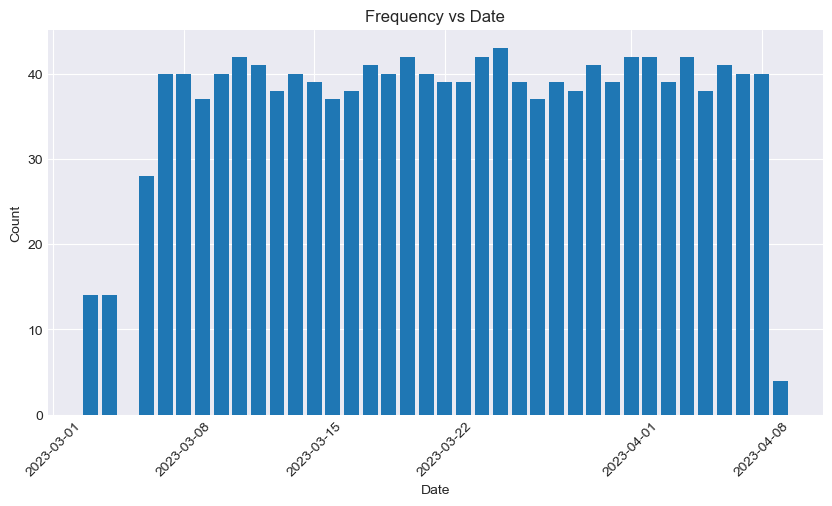

In [8]:
# Copying the dataset
df1 = df.copy() 
df1['Data'] = pd.to_datetime(df1['Date']).dt.date
df1['Time'] = pd.to_datetime(df1['Date']).dt.time

# Group the dataset by date
tst = df1.groupby(['Data']).size().reset_index(name='counts')

plt.figure(figsize = (10,5))
plt.bar(x = tst['Data'], height = tst['counts'])
plt.xticks(rotation = 45)
plt.title('Frequency vs Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


We notice that there are not much observations on 03/03, 04/03 and that there are no observations at all on 05/03. So we crop the dataset and we make it start from 06/03.

In [9]:
df = df[df['Date'] >= pd.to_datetime("2023-03-06 00:00:00", format='%Y-%m-%d %H:%M:%S')]

At this point we create the predictors 'Month', 'Day', 'Hour', 'Minute' for a better visualization.

In [10]:
def get_month(dt):
    '''Takes a time timestamp as input and returns the month'''
    return dt.month

def get_day(dt):
    '''Takes a time timestamp as input and returns the day'''
    return dt.day

def get_hour(dt):
    '''Takes a time timestamp as input and returns the hour'''
    return dt.hour

def get_minutes(dt):
    '''Takes a time timestamp as input and returns the minutes'''
    return dt.minute

# Adding the new variables to the dataframe
df['Hour'] = df['Date'].apply(get_hour)
df['Minutes'] = df['Date'].apply(get_minutes)
df['Day'] = df['Date'].apply(get_day)
df['Month'] = df['Date'].apply(get_month)

# Timestamp as index
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
del df['Date']

# Descriptive analysis

We perform a descriptive analysis of the variables “Colony Activity”, “Dead Colony Weight”, “Nest Temperature”, “Nest Humidity”, “White Luminous Intensity”, “Sound Intensity” and “Nest Weight”.  
Therefore, firstly, we graph each of the variables through a histogram and calculate two numerical measures of shape (skewness and kurtosis).
The histogram is one of the most used graphs to represent quantitative variables as it allows you to quickly get an idea of the distribution of the variable, and then to understand whether the data are approximately symmetrical or clearly asymmetrical, and to verify the possible presence of outliers.

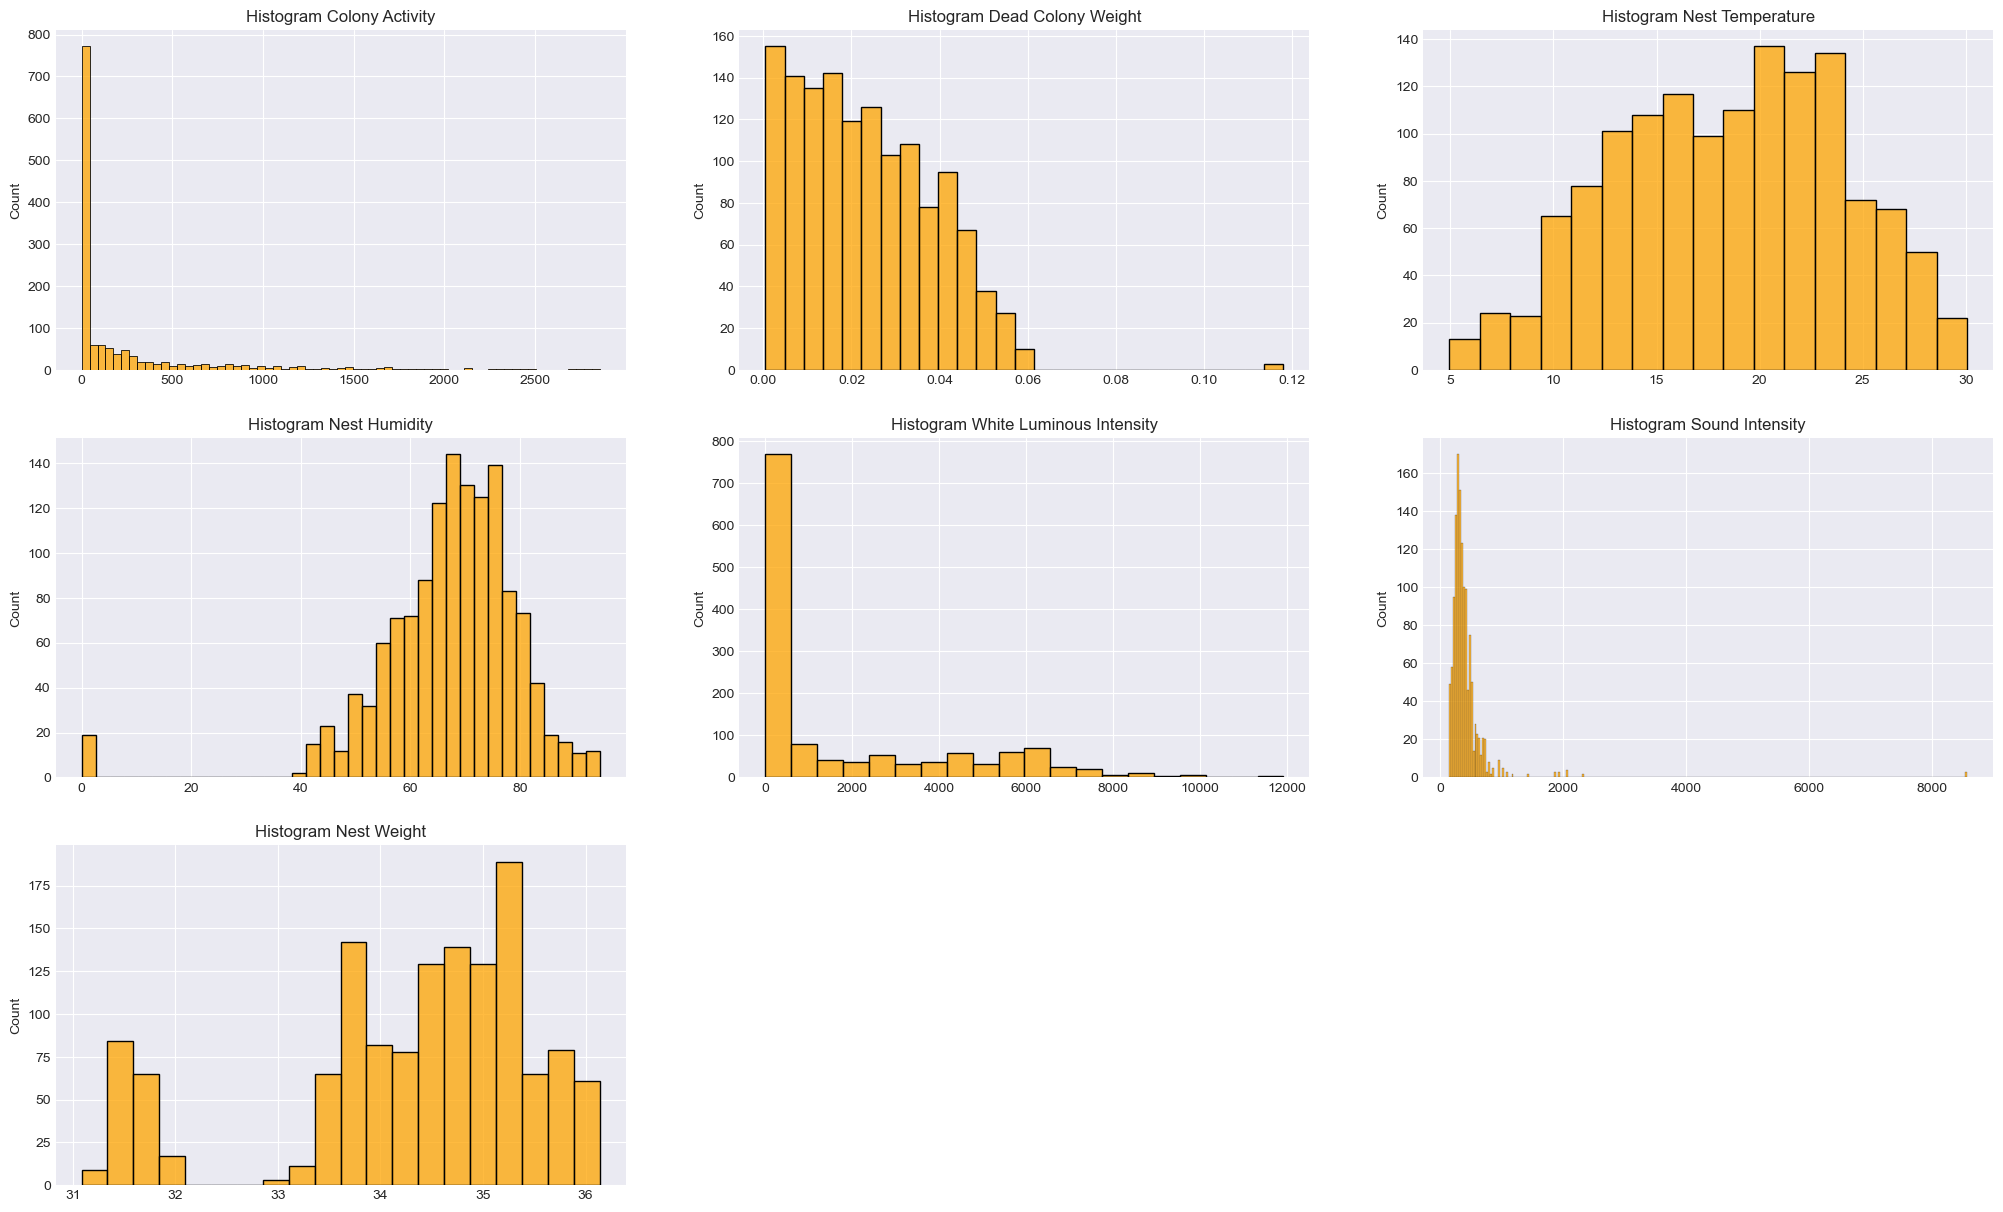

,Colony Activity,Dead Colony Weight,Nest Temperature,Nest Humidity,White Luminous Intensity,Sound Intensity,Nest Weight
Kurtosis,7.84,1.88,-0.79,8.29,0.59,249.27,0.36
Skewness,2.67,0.79,-0.12,-1.94,1.27,14.14,-1.05


In [11]:
# Histograms for each feature

features = ['Colony Activity', 'Dead Colony Weight', 'Nest Temperature',
       'Nest Humidity', 'White Luminous Intensity', 'Sound Intensity', 'Nest Weight']


# Creating a figure with 9 subplots

row = 0
fig, axes = plt.subplots(3, 3, figsize = (25,15))

for i in range(len(features)):
       col  = i%3

       # Plotting the histograms
       sns.histplot(data = df, x = features[i], ax = axes[row, col], color = 'orange')  
       axes[row,col].set_title(f'Histogram {features[i]}')
       
       if row == 3 and col == 0:
              axes[row, col].set_xlabel('Hour')
       elif row == 2 and col == 1:
              axes[row, col].set_xlabel('Hour')
       else:
              axes[row, col].set_xlabel(None)

       if col == 2:
              row+=1
       

# Hiding two subplots because we have only 7 features
axes[2,1].set_visible(False)
axes[2,2].set_visible(False)
 
plt.show()

# Creating a dataframe in which we store the kurtosis and skewness' indexes for each feature
for i in range(len(features)):      

    kurtosis = df[features[i]].kurt(axis = 0)
    skew = df[features[i]].skew(axis = 0)
    
    index_names = ['Kurtosis', 'Skewness']
    index_values = [kurtosis, skew]
    statistics = pd.Series(data = index_values, index = index_names)

    if i==0:
        df_statistics = pd.DataFrame(data = round(statistics,2), columns = [features[i]])
    else:
        df_statistics[features[i]] = round(statistics,2)

        
df_statistics



Observing the histograms, it can be seen that Colony Activity, Dead Colony Weight, White Luminous Intensity and Sound Intensity present a distribution characterized by positive asymmetry. On the contrary, Nest Temperature, Nest Humidity and Nest Weight have a distribution characterized by negative asymmetry. These asymmetries, which are more or less strong, are confirmed by the Skewness Index.  
In particular, Colony Activity, Dead Colony Weight, Nest Humidity, White Luminous Intensity, Sound Intensity and Nest Weight have a leptokurtic curve, while Nest Temperature has a platykurtic curve. The shape of these curves is confirmed by the Kurtosis Index.  
Moreover, the variables Dead Colony Weight, Nest Humidity and Sound Intensity have some values that are clearly distant from the rest of the distribution. Therefore, we can consider them as outliers and replace them with the mean value.

In [12]:
# Finding the evident outliers for Dead Colony Weight, Nest Humidity, Sound Intensity
df_outlier1 = df[df['Dead Colony Weight'] > 0.1]
df_outlier2 = df[df['Nest Humidity'] < 10]
df_outlier3 = df[df['Sound Intensity'] > 6000]

# Replacing the evident outliers of Dead Colony Weight
df_no_out = df.drop(df_outlier1.index)
sub_1 = np.mean(df_no_out['Dead Colony Weight'])
df_outlier1['Dead Colony Weight'] = sub_1
df = df_no_out.append(df_outlier1).sort_index()

# Dropping the evident outliers for Nest Humidity
df_no_out = df.drop(df_outlier2.index)
sub_2 = np.mean(df_no_out['Nest Humidity'])
df_outlier2['Nest Humidity'] = sub_2
df = df_no_out.append(df_outlier2).sort_index()

# Dropping the evident outliers for Sound Intensity
df_no_out = df.drop(df_outlier3.index)
sub_3 = np.mean(df_no_out['Sound Intensity'])
df_outlier3['Sound Intensity'] = sub_3
df = df_no_out.append(df_outlier3).sort_index()


To identify any outlier with greater precision, we construct a boxplot for each variable.  
The boxplot is one of the most used graphical tools as it allows to represent five of the most used position measures in statistics (minimum value, first quartile, median, third quartile and maximum value) and to precisely identify the outliers. In fact, if there were outliers, these would be represented in the boxplot as isolated points positioned above and/or below the whiskers of the distribution.

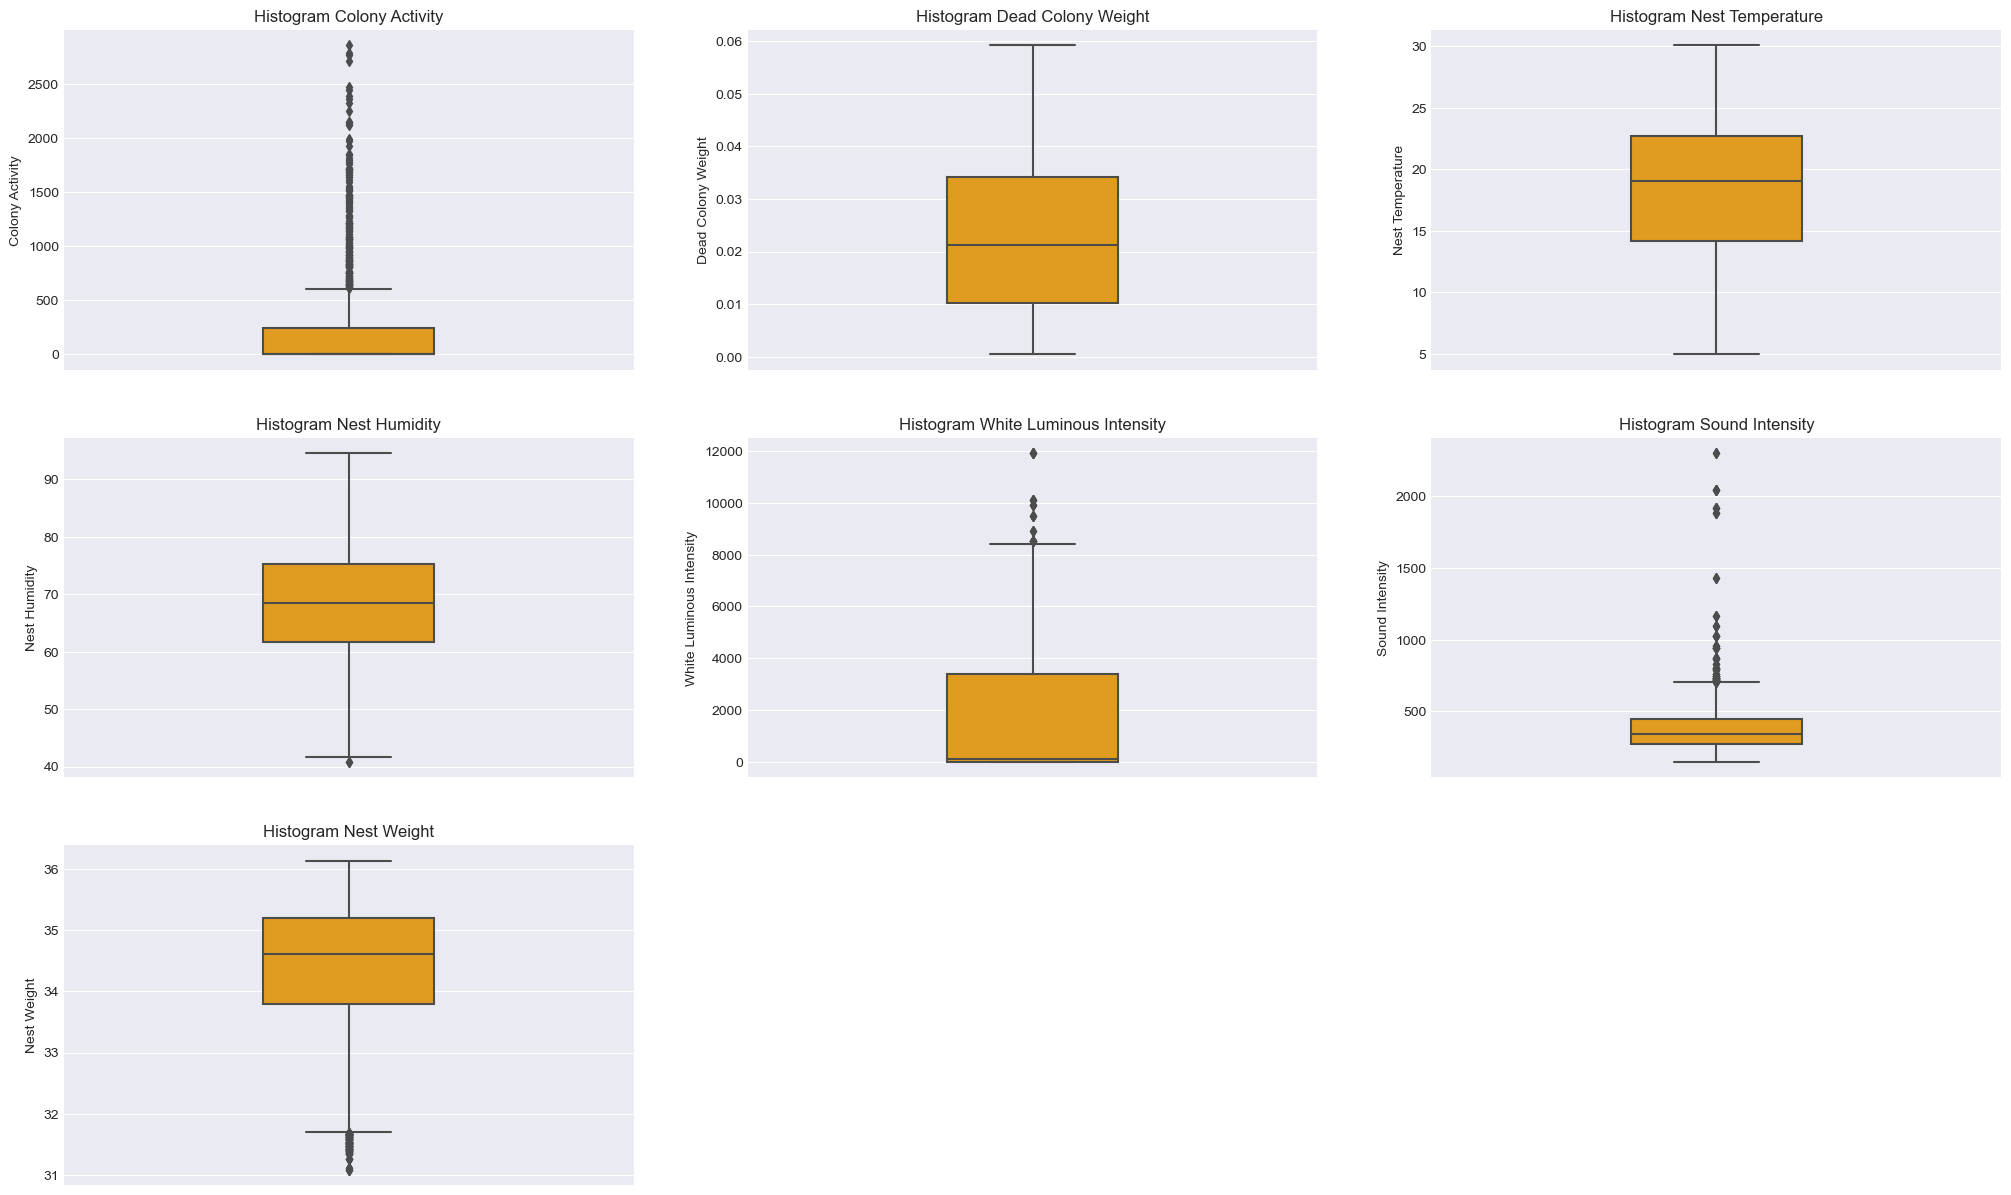

In [13]:
# Boxplots for each variable

features = ['Colony Activity', 'Dead Colony Weight', 'Nest Temperature',
       'Nest Humidity', 'White Luminous Intensity', 'Sound Intensity', 'Nest Weight']

# Creating a figure with 9 subplots
row = 0
fig, axes = plt.subplots(3, 3, figsize = (25,15))

for i in range(len(features)):
       col  = i%3
       
       # Plotting the boxplot
       sns.boxplot(data = df, y = features[i], ax = axes[row, col], color = 'orange', width = 0.3)  
       axes[row,col].set_title(f'Histogram {features[i]}')
       
       if row == 3 and col == 0:
              axes[row, col].set_xlabel('Hour')
       elif row == 2 and col == 1:
              axes[row, col].set_xlabel('Hour')
       else:
              axes[row, col].set_xlabel(None)

       if col == 2:
              row+=1
       
# Hiding two subplots because we have only 7 features
axes[2,1].set_visible(False)
axes[2,2].set_visible(False)
 
plt.show()


Looking at the boxplots, we notice the presence of points above/below the whiskers of the distribution of the variables Colony Activity, White Luminous Intensity, Sound Intensity and Nest Weight. Therefore, we could treat such points as potential outliers and assign them, for example, the mean value. However, this would not be correct since the time factor has not being taken into account. Hence, we construct a boxplot of each variable considering each time of day. 

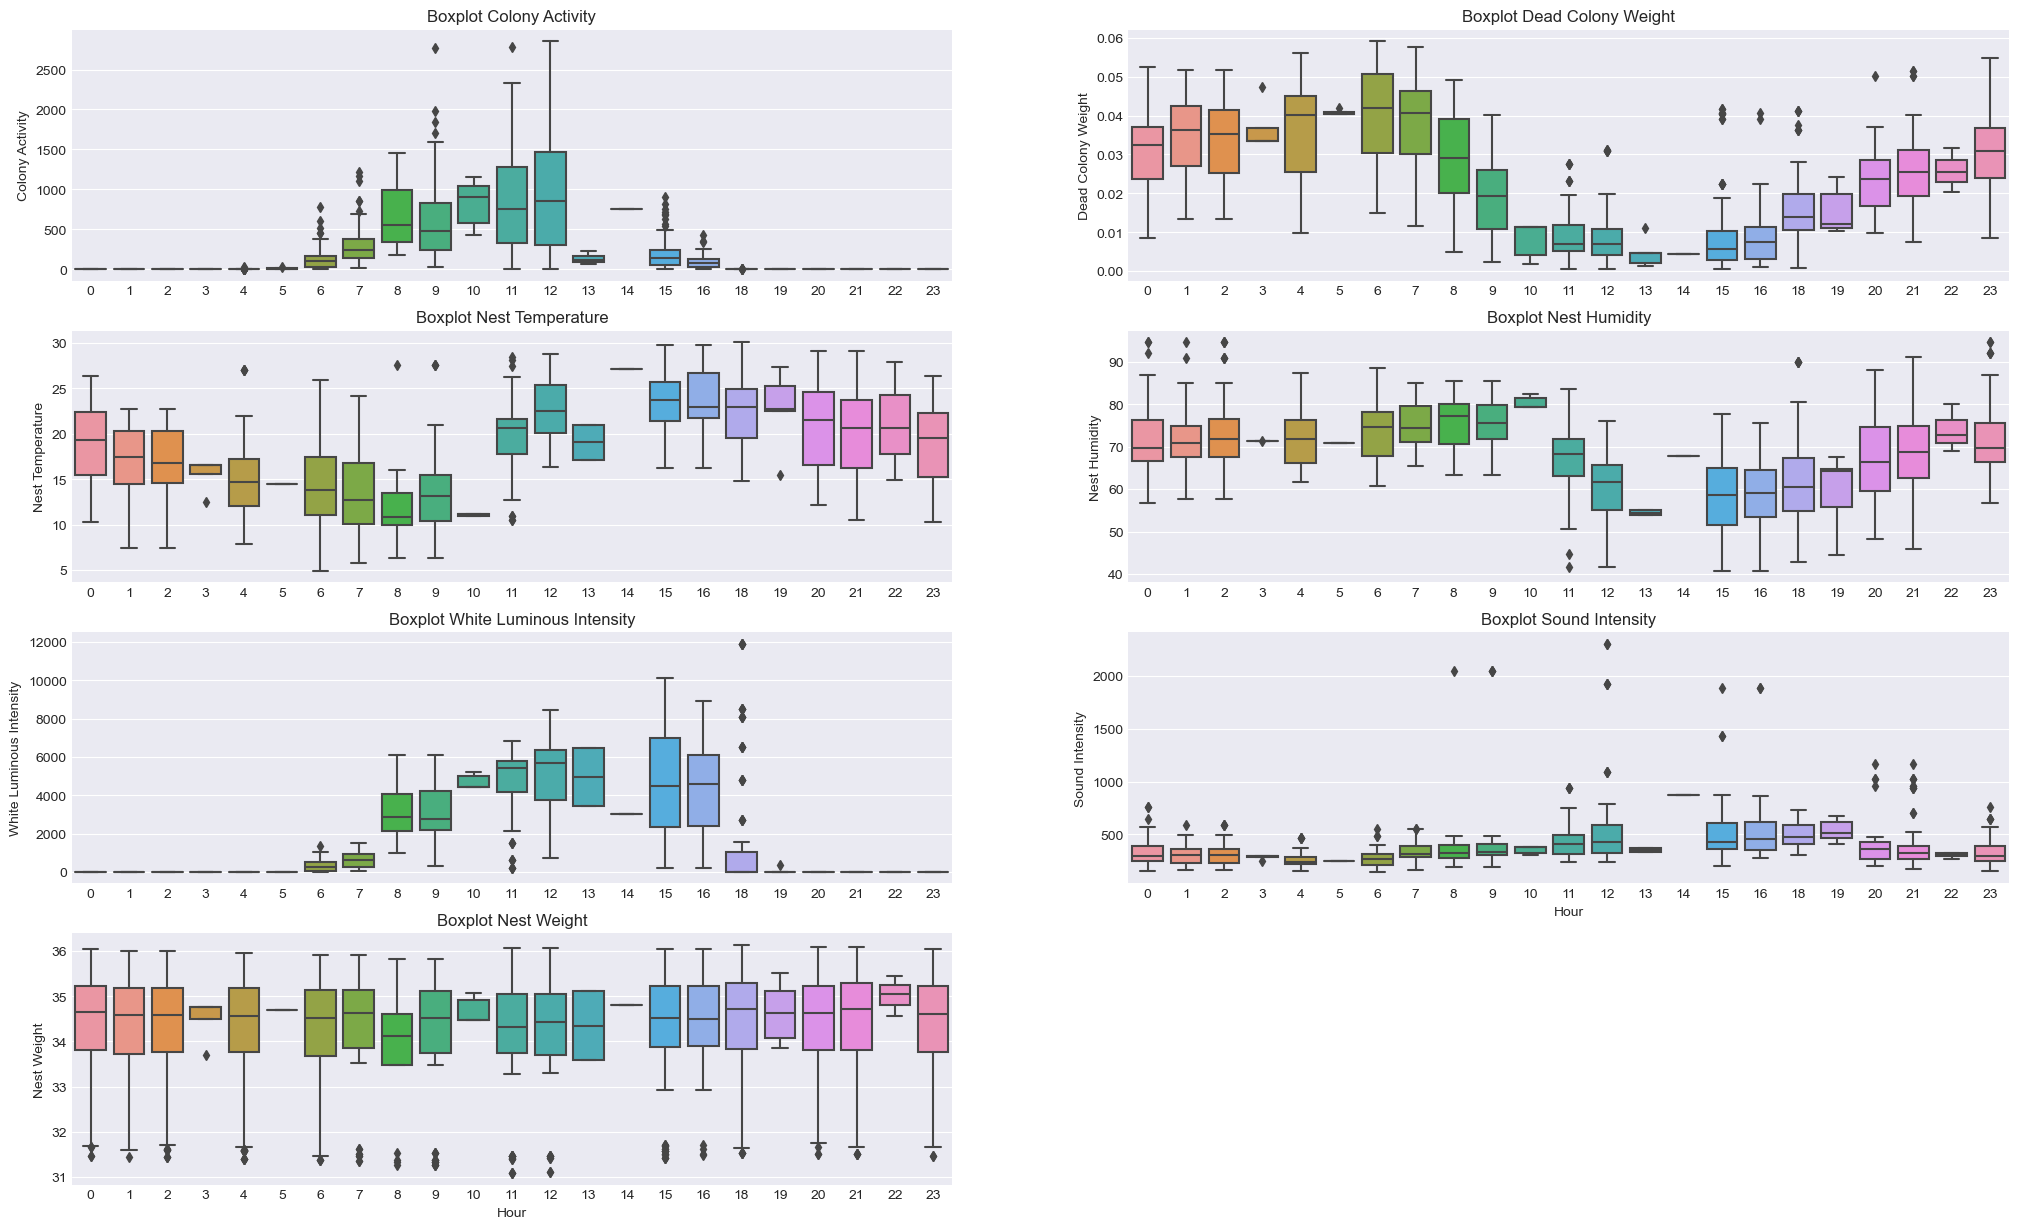

In [14]:
features = ['Colony Activity', 'Dead Colony Weight', 'Nest Temperature',
       'Nest Humidity', 'White Luminous Intensity', 'Sound Intensity', 'Nest Weight']

# Creating a figure with 8 subplots
row = 0
fig, axes = plt.subplots(4, 2, figsize = (25,15))

for i in range(len(features)):
       col  = i%2

       # Plotting the grouped boxplots for hour
       sns.boxplot(data = df, x = 'Hour', y = features[i], ax = axes[row,col])   
       axes[row,col].set_title(f'Boxplot {features[i]}')
       
       if row == 3 and col == 0:
              axes[row, col].set_xlabel('Hour')
       elif row == 2 and col == 1:
              axes[row, col].set_xlabel('Hour')
       else:
              axes[row, col].set_xlabel(None)

       if col == 1:
              row+=1

# Hiding one subplot because the features are 7
axes[3,1].set_visible(False)
 
plt.show()

Illustrating the boxplot of each variable in this way, we can spot the outliers with respect to the distributions of the variables for each hour of the day.  
We can observe the trend of these variables, theirs drops and peaks and detect the true outliers through Power BI.  
An interesting fact, there are not measurements at 5 p.m.!

Now we can export the final dataframe and move our analysis on Power BI

In [15]:
# df.to_csv('data_bi.csv', sep = ',')

# Time series analysis

#### Granger test
First of all, we have done the Granger causality test that is a statistical hypothesis test for determining whether one time series is useful in forecasting another.
If we focus on the p-values that result from this test, we can observe that, all the variables granger causes Nest Weight_y as all the p-values are less than the significance level.

In [16]:

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=10, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(10)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grang = grangers_causation_matrix(df, variables = features) 
grang.style.background_gradient(cmap='coolwarm').set_precision(4)

,Colony Activity_x,Dead Colony Weight_x,Nest Temperature_x,Nest Humidity_x,White Luminous Intensity_x,Sound Intensity_x,Nest Weight_x
Colony Activity_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0170
Dead Colony Weight_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0098,0.0044
Nest Temperature_y,0.0000,0.0000,1.0000,0.0208,0.0000,0.0059,0.0070
Nest Humidity_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0007,0.0000
White Luminous Intensity_y,0.0000,0.0000,0.0000,0.0002,1.0000,0.2764,0.0000
Sound Intensity_y,0.0000,0.0000,0.0000,0.0001,0.0000,1.0000,0.0006
Nest Weight_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0098,1.0000


#### Decomposition

Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category.
There are three types of time series patterns: trend, seasonality and cycles. When we decompose a time series into components, we usually combine the trend and cycle into a single trend-cycle component (sometimes called the trend for simplicity). Thus we think of a time series as comprising three components: a trend-cycle component, a seasonal component, and a remainder component (containing anything else in the time series). A common method for extracting these components from a time series is the Multiplicative decomposition, which consists of the multiplication of the three components, or additive decomposition which consists of the sum of the three components.  
We chose the additive decomposition because it is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series.  
In our case we can observe that the trend is not constant but is basically increasing except for the two drops. As regard the seasonality we can see that it occurs regularly.

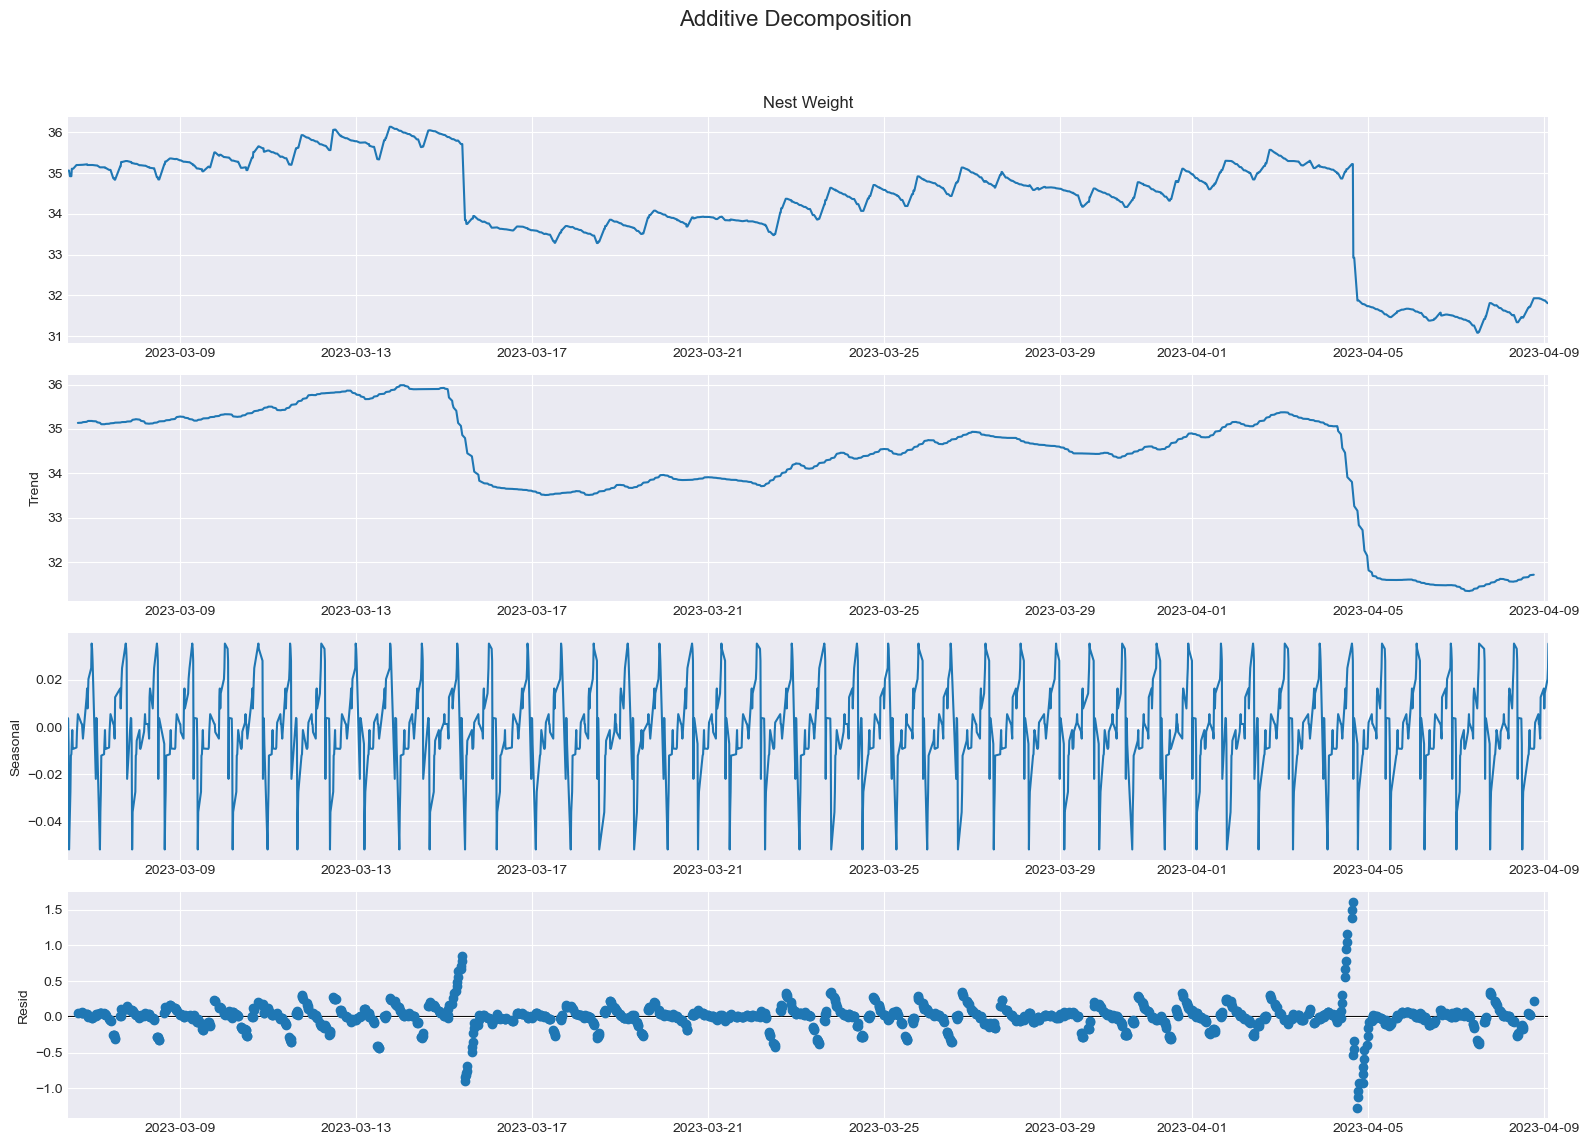

In [17]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(df['Nest Weight'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#### ACF, PACF, Lag Plots

Then we have done the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) that are used to figure out the order of AR, MA, and ARMA models.Autocorrelation is the correlation between a time series with a lagged version of itself. The ACF starts at a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.  
The partial autocorrelation at lag k is the autocorrelation between X_t and X_(t-k) that is not accounted for by lags 1 through 𝑘−1. 
The x-axis of the ACF graph indicates the lag with which the autocorrelation is calculated; the y-axis indicates the value of the correlation (between -1 and 1 ).
A positive correlation indicates that the largest current values correspond to the largest values at the specified lag; a negative correlation indicates that the largest current values correspond to the smallest values at the specified lag.  
The absolute value of a correlation is a measure of the intensity of the association: larger absolute values indicate stronger relationships. In our case we observe that we have a degree of autocorrelation that is about 75. 

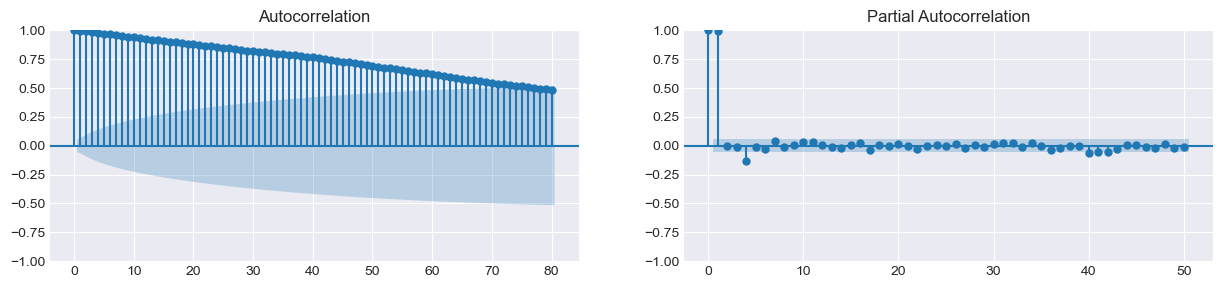

In [18]:
# Plotting autocorrelation and partial autocorrelation functions
fig, axes = plt.subplots(1,2,figsize=(15,3), dpi= 100)
plot_acf(df['Nest Weight'].tolist(), lags=80, ax=axes[0])
plot_pacf(df['Nest Weight'].tolist(), lags=50, ax=axes[1])
plt.show()

We have done the Lag Plot. A lag plot is a special type of scatter plot with the two variables (X,Y) “lagged.” Plots with a single plotted lag are the most common. However, it is possible to create a lag plot with multiple lags with separate groups representing each lag. Lag plots allow you to check for model suitability, outliers, randomness , serial correlation and seasonality. 

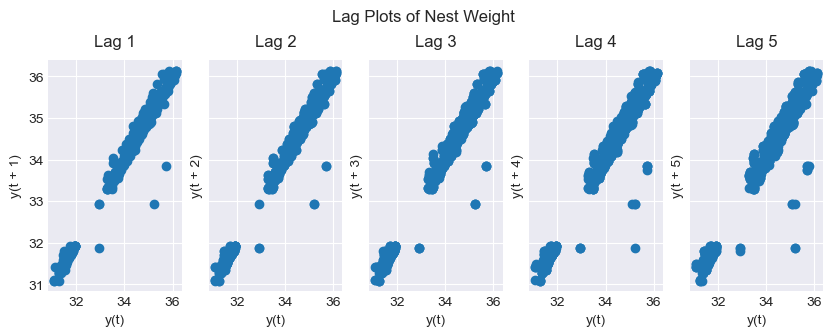

In [19]:
# Plotting the correlation between lags
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(1, 5, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(df['Nest Weight'], lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Nest Weight', y=1.05)    
plt.show()

As regards model suitability we can see that, in our case, we have a linear shape of the plot that suggests that an autoregressive model could be a good choice.
We can see that there is a small number of outliers.
This linear pattern also indicates the data is not random and autocorrelation is present. We can observe a positive linear trend that is suggestive of positive autocorrelation.  
The tighter the data is clustered around the diagonal, the more autocorrelation is present.  
  
Later we have done the Augmented Dickey Fuller's test (ADF test) that is a common statistical test used to test whether a given time series is stationary or not.  
One point to remember is that the ADF test is basically a test of statistical significance. This means that it is a hypothesis test with a null hypothesis and an alternative hypothesis, and as a result, a test statistic is calculated and p-values are reported. From the p-value it can be inferred whether a given series is stationary or not. The null hypothesis of the test is that the time series has a unit root, that is a special case of non-stationarity, where the time series has a stochastic trend that persists over time. The alternative hypothesis is that it is stationary. 

In [20]:
# Creating dataframe with ADF tests' results for each variable
features = ['Colony Activity', 'Dead Colony Weight', 'Nest Temperature',
       'Nest Humidity', 'White Luminous Intensity', 'Sound Intensity', 'Nest Weight']

pvalues = []
for i in features:
    dftest = sm.tsa.adfuller(df1[i], regression='ct')
    pvalue = dftest[1]
    pvalues.append(pvalue)
adf_tests = pd.DataFrame(data = pvalues, index = features, columns = ['p-value']).T
adf_tests


,Colony Activity,Dead Colony Weight,Nest Temperature,Nest Humidity,White Luminous Intensity,Sound Intensity,Nest Weight
p-value,8.464148e-18,5.958428e-16,2.692776e-16,0.00002,1.554376e-19,1.103567e-15,0.455968


We can observe that almost all the p-values are less than the significance level so we can reject the null hypothesis. The only p-value that is greater than the significance level is the one connected to Nest Weight that is the only one which is not stationary.  
Thereby we have applied the differencing technique to transform a non-stationary time series into a stationary one. It involves subtracting the current value of the series from the previous one, or from a lagged value.  
As a result, the variable Nest Weight became stationary after the first difference as we can see applying another time the ADF test on the differenciate Nest Weight.

In [21]:
# ADF test for the target Nest Weight after differencing
dftest = sm.tsa.adfuller(df['Nest Weight'].diff().dropna(), regression='ct')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                -1.371925e+01
p-value                        2.036103e-21
#Lags Used                     5.000000e+00
Number of Observations Used    1.340000e+03
Critical Value (1%)           -3.965542e+00
Critical Value (5%)           -3.413771e+00
Critical Value (10%)          -3.128982e+00
dtype: float64


# Machine learning

To forecast the variable Nest Weight we use a tree-based model: the XGBoost (tree models with boosting). The XGBoost method generally outperforms  normal gradient boosting trees because it uses regularization like $L1$ and $L2$, which improves model generalization capabilities.  
The only problem is that this kind of models cannot take the timestamps and the exogenous variables in the training and only the timestamp in the testing bit. So we start with a model trained only on the variables derived from the timestamps.  
To notice that we don't use Nest Weight as target but Nest Weight after differencing. We do that because forecasting a stationary time series results simpler than forecasting a non stationary one.

## XGBoost (without exogenous)

In [22]:
# Differencing the target
df['Nest_Weight_diff'] = df['Nest Weight'].diff().fillna(0)

# Selecting the features for training and the target
features = ['Month', 'Day', 'Hour', 'Minutes']
target = 'Nest_Weight_diff'

### Cross validation + Tuning

We do a hyperparameters' tuning with cross validation to find the best model. The parameters' space is:  
- max_depth (maximum depth of the trees): from 1 to 5
- min_child_weight (minimum number of data in a leaf to avoid overfitting): from 0 to 4
- learning rate (quando un albero è aggiunto agli esistenti viene moltiplicato per il learning rate): from 0 to 0.4

For cross validation we use a 3-fold training. Generally it's used with 5 or 10 folds but the dataset is quite small for that kind of CV.  
The booster 'gbtree' returns a normal gradient boosted model.


In [23]:
tss = TimeSeriesSplit(n_splits = 3, test_size = 100)
max_depth_lst = list(range(1,6))
min_child_w_lst = list(range(0,5))
l_r_lst = list(range(0,5))

scores = []
models = []

# Hyperparameters' tuning
for max_depth in max_depth_lst:
    for min_child_weight in min_child_w_lst:
            for l_r in l_r_lst:
                learning_rate = l_r/10
                
                scores_cv = []
                # Cross Validation
                for train_idx, val_idx in tss.split(df):

                        train = df.iloc[train_idx]
                        test = df.iloc[val_idx]
                        
                        X_train = train[features]
                        y_train = train[target]

                        X_test = test[features]
                        y_test = test[target]

                        # Training the regressor
                        reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, max_depth = max_depth, 
                                               min_child_weight = min_child_weight, learning_rate = learning_rate, booster = 'gbtree')
                        
                        reg.fit(X_train, y_train,
                                eval_set = [(X_train, y_train), (X_test, y_test)],
                                verbose = False)

                        # Predicting the target for the test dataset
                        y_pred= reg.predict(X_test)

                        # Transforming Nest_Weight_diff predictions in Nest Weight predictions
                        y_pred_diff = list(y_pred)
                        nest_weight_last = train['Nest Weight'][-1]
                        y_pred = [nest_weight_last]
                        for j in y_pred_diff[1:]:
                                nest_weight_last += j
                                y_pred.append(nest_weight_last)

                        # Mean square error to evaluate performance
                        mse = mean_squared_error(y_pred, test['Nest Weight'])
                        scores_cv.append(mse)
                        
                # Average of MSE after cross validation
                score = np.mean(scores_cv)

                # Print the model's parameters
                print('*********************\nParameters:')
                print(f'Max Depth: {max_depth}')
                print(f'Min Child Weight: {min_child_weight}')
                print(f'Learning rate: {learning_rate}')
                print (f"MSE: {round(score, 3)}")

                param_score = (max_depth, min_child_weight, learning_rate, score)
                models.append(param_score)



# Selection of the best model
scores = [x[-1] for x in models]
index = scores.index(min(scores))
best_model = models[index]

print('*********** Best Model ***********')
print(f'Max Depth: {best_model[0]}')
print(f'Min Child Weight: {best_model[1]}')
print(f'Learning rate: {best_model[2]}')
print ("MSE:", round(best_model[3], 3))



*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.0
MSE: 875.218
*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.1
MSE: 3.25
*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.2
MSE: 3.203
*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.3
MSE: 3.391
*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.4
MSE: 3.334
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.0
MSE: 875.218
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.1
MSE: 3.25
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.2
MSE: 3.203
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.3
MSE: 3.391
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.4
MSE: 3.334
*********************
Parame

The best model selected is the one with the smallest mean squared error. At this point we re-run that model with a cross validation to show the results of the predictions

### Best model from CV

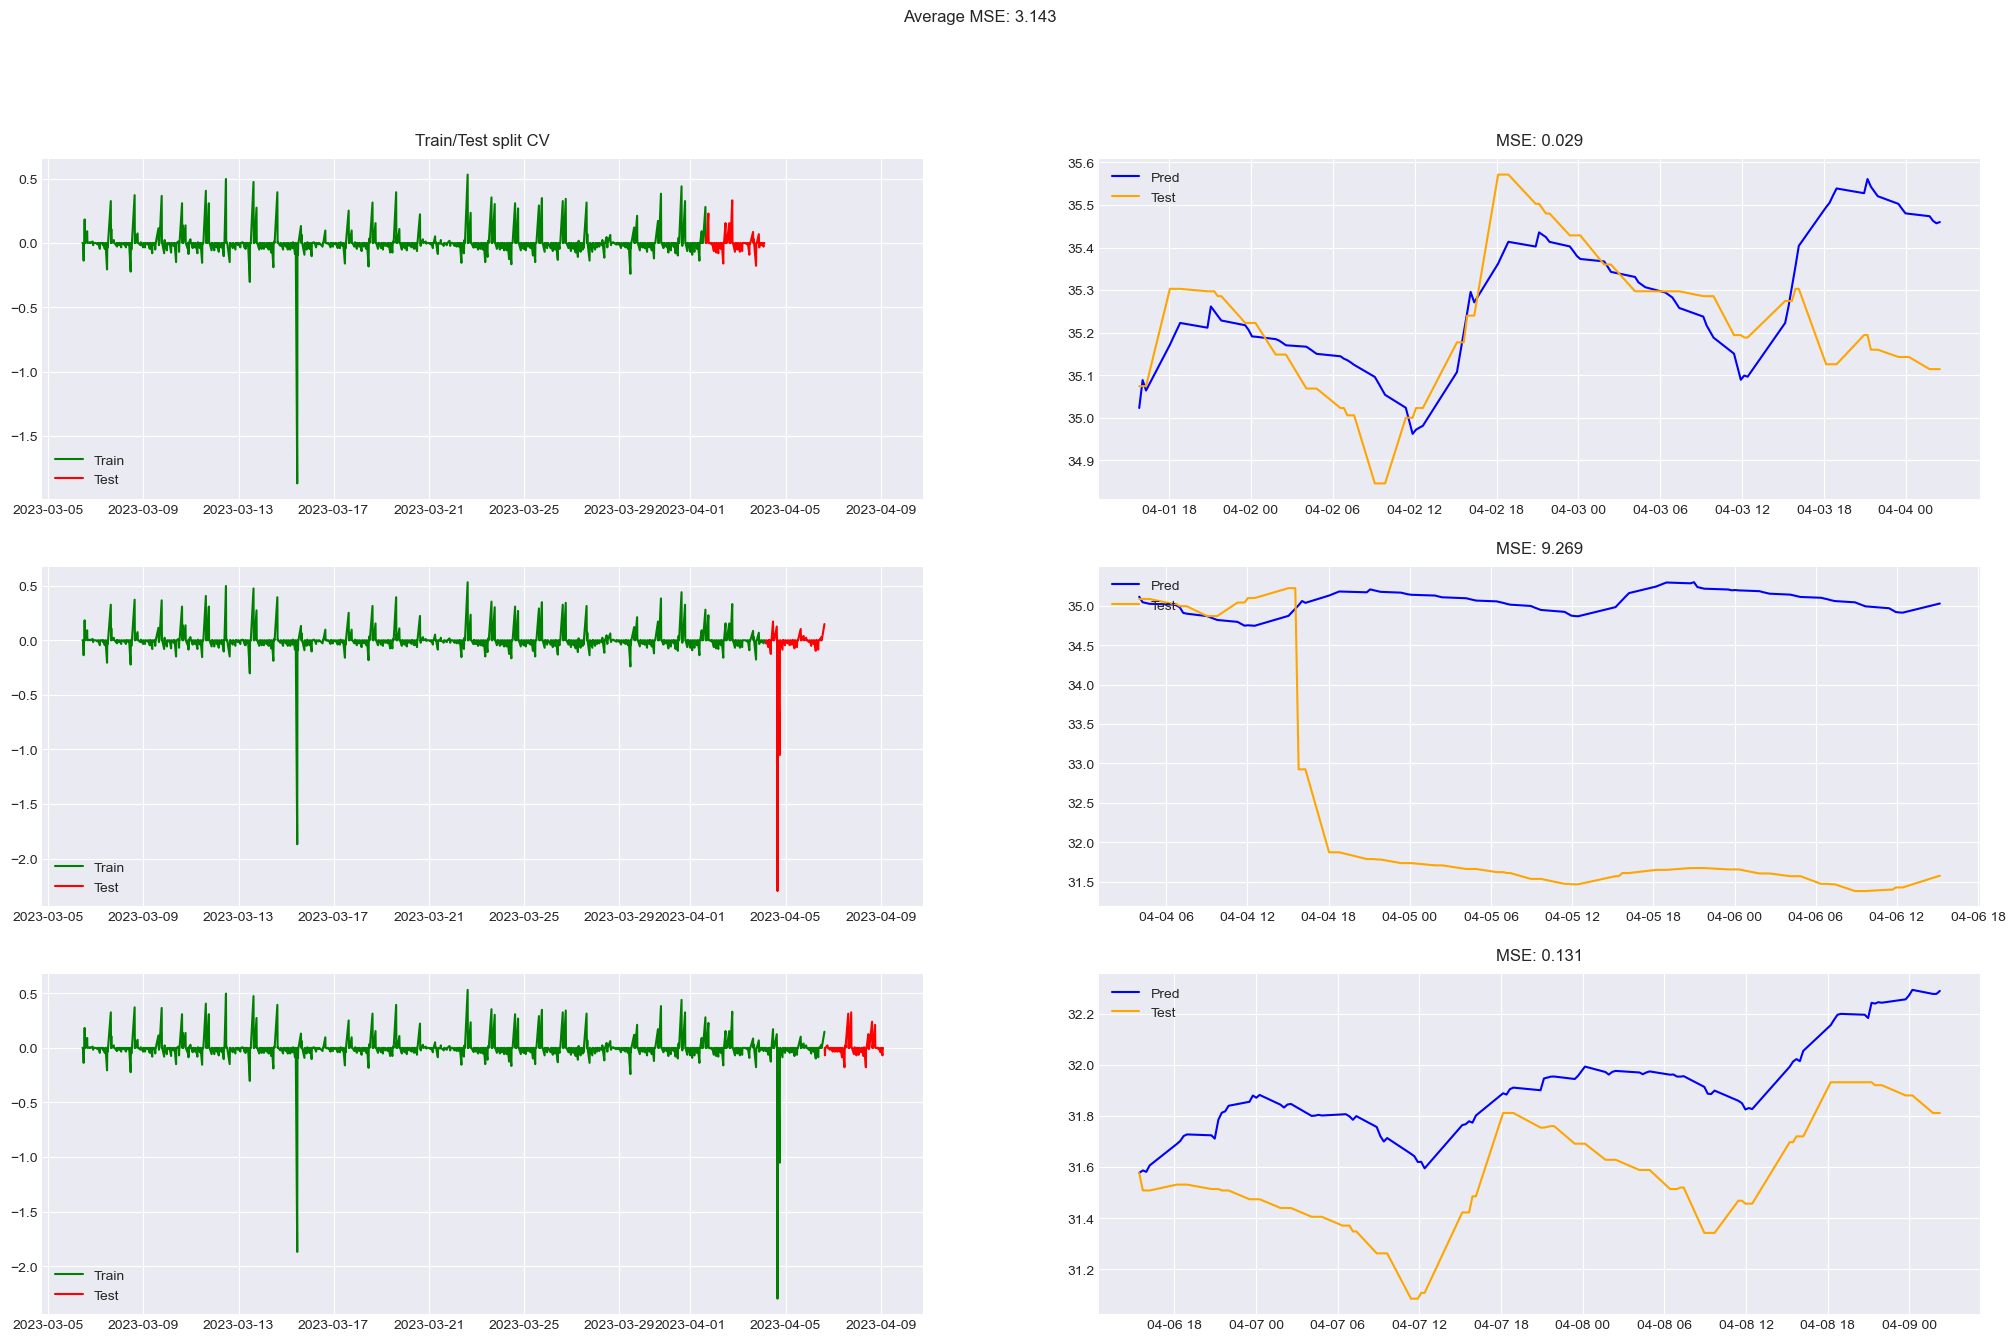

In [24]:
# Re-running the model and plotting the results

fig,ax = plt.subplots(3,2, figsize = (25,15))
i = 0
scores_cv = []

for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        # Plotting train and test split
        ax[i,0].plot(train[target], color = 'green', label = 'Train')
        ax[i,0].plot(test[target], color = 'red', label = 'Test')
        
        X_train = train[features]
        y_train = train[target]

        X_test = test[features]
        y_test = test[target]

        reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, max_depth = best_model[0], min_child_weight = best_model[1], learning_rate = best_model[2], booster = 'gbtree')
        reg.fit(X_train, y_train,
                eval_set = [(X_train, y_train), (X_test, y_test)],
                verbose = False)

        y_pred= reg.predict(X_test)

        y_pred_diff = list(y_pred)
        nest_weight_last = train['Nest Weight'][-1]
        y_pred = [nest_weight_last]
        for j in y_pred_diff[1:]:
                nest_weight_last += j
                y_pred.append(nest_weight_last)
                
        score = mean_squared_error(y_pred, test['Nest Weight'])
        scores_cv.append(round(score, 3))
        
        # Plotting test values and predictions
        ax[i,1].plot(X_test.index, y_pred, color = 'blue', label = 'Pred')
        ax[i,1].plot(X_test.index, test['Nest Weight'], color = 'orange', label = 'Test')
        ax[i,1].set_title(f'MSE: {scores_cv[i]}')
        ax[i,1].legend(loc = 'upper left')
        ax[i,0].legend(loc = 'lower left')
        i+=1


score_cv = np.mean(scores_cv)

fig.suptitle(f'Average MSE: {round(score_cv, 3)}')
ax[1,0].sharex(ax[2,0])
ax[0,0].sharex(ax[2,0])
ax[0,0].set_title('Train/Test split CV')
plt.show()


We have an average MSE = 3.143 but we can see how the reason for this high value is the second fold of validation. In fact in this fold in the training we see the drop that we pointed out in the previous analysis'. The other mean sqaured errors are significatevely smaller with values of 0.029 and 0.131

### Feature Importance
With tree-based models we can plot the feature importance. In this case without exogenous variables there is not much to say. The only thing is that only the Month variable has a small importance, but we could expect that given that the dataset covers only two months. April has only 9 days and almost all of them are alwasy in the testing set. So, in the training, the month variable is less significative.

<AxesSubplot:title={'center':'Importance'}>

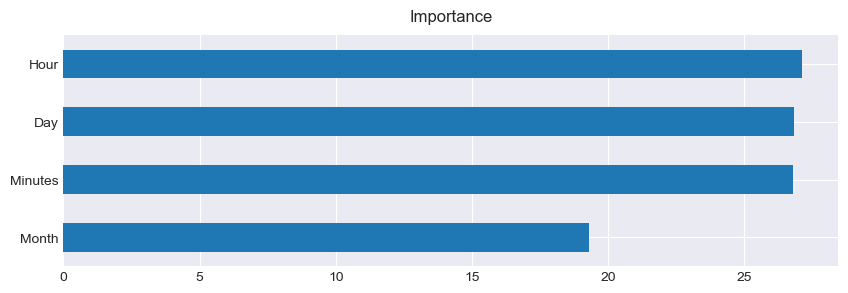

In [25]:
# Plotting the feature importance as percentages
impor = pd.DataFrame(data = reg.feature_importances_ * 100, index = reg.feature_names_in_, columns = ['importance'])
impor.sort_values('importance').plot(kind = 'barh', title = 'Importance', legend=False, figsize = (10,3))

## Submission prediction

Now that we've found the best model we can begin to import the file 'submission_data.csv' and preproccess it in the same way we did for train_data

In [26]:
# Importing submissiondata.csv
df_sub = pd.read_csv('submission_data.csv')

# Convert Date variable from string to timestamp
df_sub['Date']= pd.to_datetime(df_sub['Date'], format='%Y-%m-%d %H:%M:%S')

# def minute_round(dt):
#  # Round to the nearest minute. If second < 30 set it to zero and leave minutes
#  # unchanged. Otherwise set seconds to zero and increase minutes by 1.
#  return (dt.replace(second=0, microsecond=0, hour=dt.hour)
#            + timedelta(minutes=dt.second//30))

# Round all timestamps to the minutes (seconds = 00)
df_sub['Date'] = df_sub['Date'].apply(minute_round)

In [27]:
def get_month(dt):
    '''Takes a time timestamp as input and returns the month'''
    return dt.month

def get_day(dt):
    '''Takes a time timestamp as input and returns the day'''
    return dt.day

def get_hour(dt):
    '''Takes a time timestamp as input and returns the hour'''
    return dt.hour

def get_minutes(dt):
    '''Takes a time timestamp as input and returns the minutes'''
    return dt.minute

# Adding the new variables to the dataframe
df_sub['Hour'] = df_sub['Date'].apply(get_hour)
df_sub['Minutes'] = df_sub['Date'].apply(get_minutes)
df_sub['Day'] = df_sub['Date'].apply(get_day)
df_sub['Month'] = df_sub['Date'].apply(get_month)

In [28]:
# Timestamp as index
df_sub.index = pd.to_datetime(df_sub['Date'], format='%Y-%m-%d %H:%M:%S')
del df_sub['Date']

At this point we can say that the whole train_data.csv is our training dataset and that we want to forecast the target for the submission_data's dates.

In [29]:
# Using train_data as training and submission_data for prevision
X_train = df[features]
y_train = df[target]

X_test = df_sub[features]

We use the best model that we found and we can predict our target. Next we plot the results and save the predictions in the variable 'prediction_xgboost_wout_ex'.

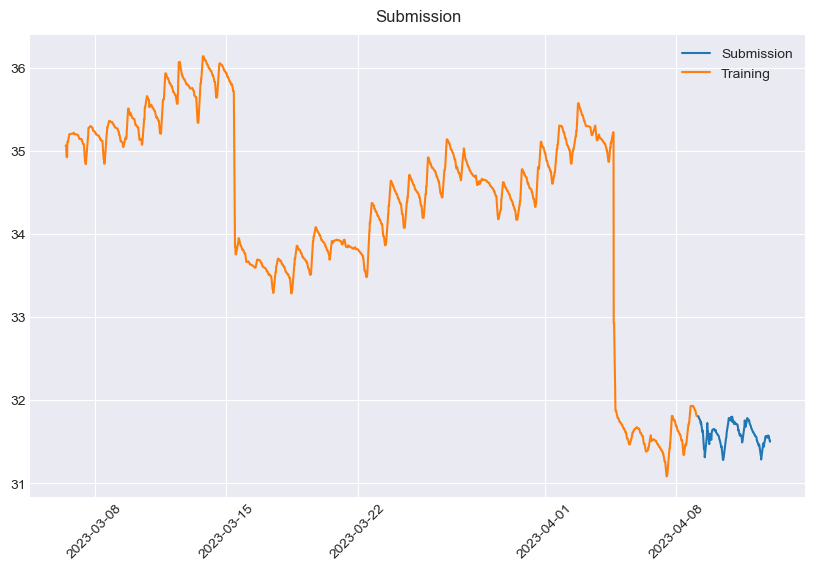

In [30]:
# Using best model for prevision
reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, max_depth = best_model[0], min_child_weight = best_model[1], learning_rate = best_model[2], booster = 'gbtree')

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train)],
        verbose = False)

# Prediction
y_pred= reg.predict(X_test)

# Transforming prediction of Nest_Weight_diff in Nest Weight prediction
y_pred_diff = list(y_pred)
nest_weight_last = df['Nest Weight'][-1]
y_pred = [nest_weight_last]
for j in y_pred_diff[1:]:
        nest_weight_last += j
        y_pred.append(nest_weight_last)

# Plotting the results
plt.figure(figsize = (10,6))  
plt.title('Submission')      
plt.plot(df_sub.index, y_pred, label = 'Submission')
plt.plot(df.index, df['Nest Weight'], label = 'Training')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [31]:
# Saving the prediction
prediction_xgboost_wout_ex = y_pred[:]

## Xgboost (with exogenous)
At this point we wonder if the other predictors would improve the performances. The problem is that in for the forecast data we have no exogenous variables. Our solution is the following: these variables are all stationary (as the ADF tests told us) so they are not so difficult to predict given that the timestamps of the forecast cover only 3-4 days. So the idea is to predict first with a tree-based models the exogenous variables for the forecast. Then we train the XGBoost Regressor with all the dataset of training and finally use the exogenous variables predicted to forecast the next days.



In [32]:
# Splitting the train_data dataset in training and testing
train = df[df.index <= pd.to_datetime("2023-04-05 0:00:00", format='%Y-%m-%d %H:%M:%S')]
test = df[df.index >= pd.to_datetime("2023-04-05 0:00:00", format='%Y-%m-%d %H:%M:%S')]


features = ['Month', 'Day', 'Hour', 'Minutes']

exog = ['Colony Activity', 'Dead Colony Weight', 'Nest Temperature',
       'Nest Humidity', 'White Luminous Intensity', 'Sound Intensity']

target = 'Nest_Weight_diff'

X_train = train[features]
exog_train = train[exog]
y_train = train[target]

X_test = test[features]
exog_test = test[exog]
y_test = test[target]

### Exogenous' prediction
Here we use a regressor not so different from the one used above to predict the exogenous variables. Then we plot the results.

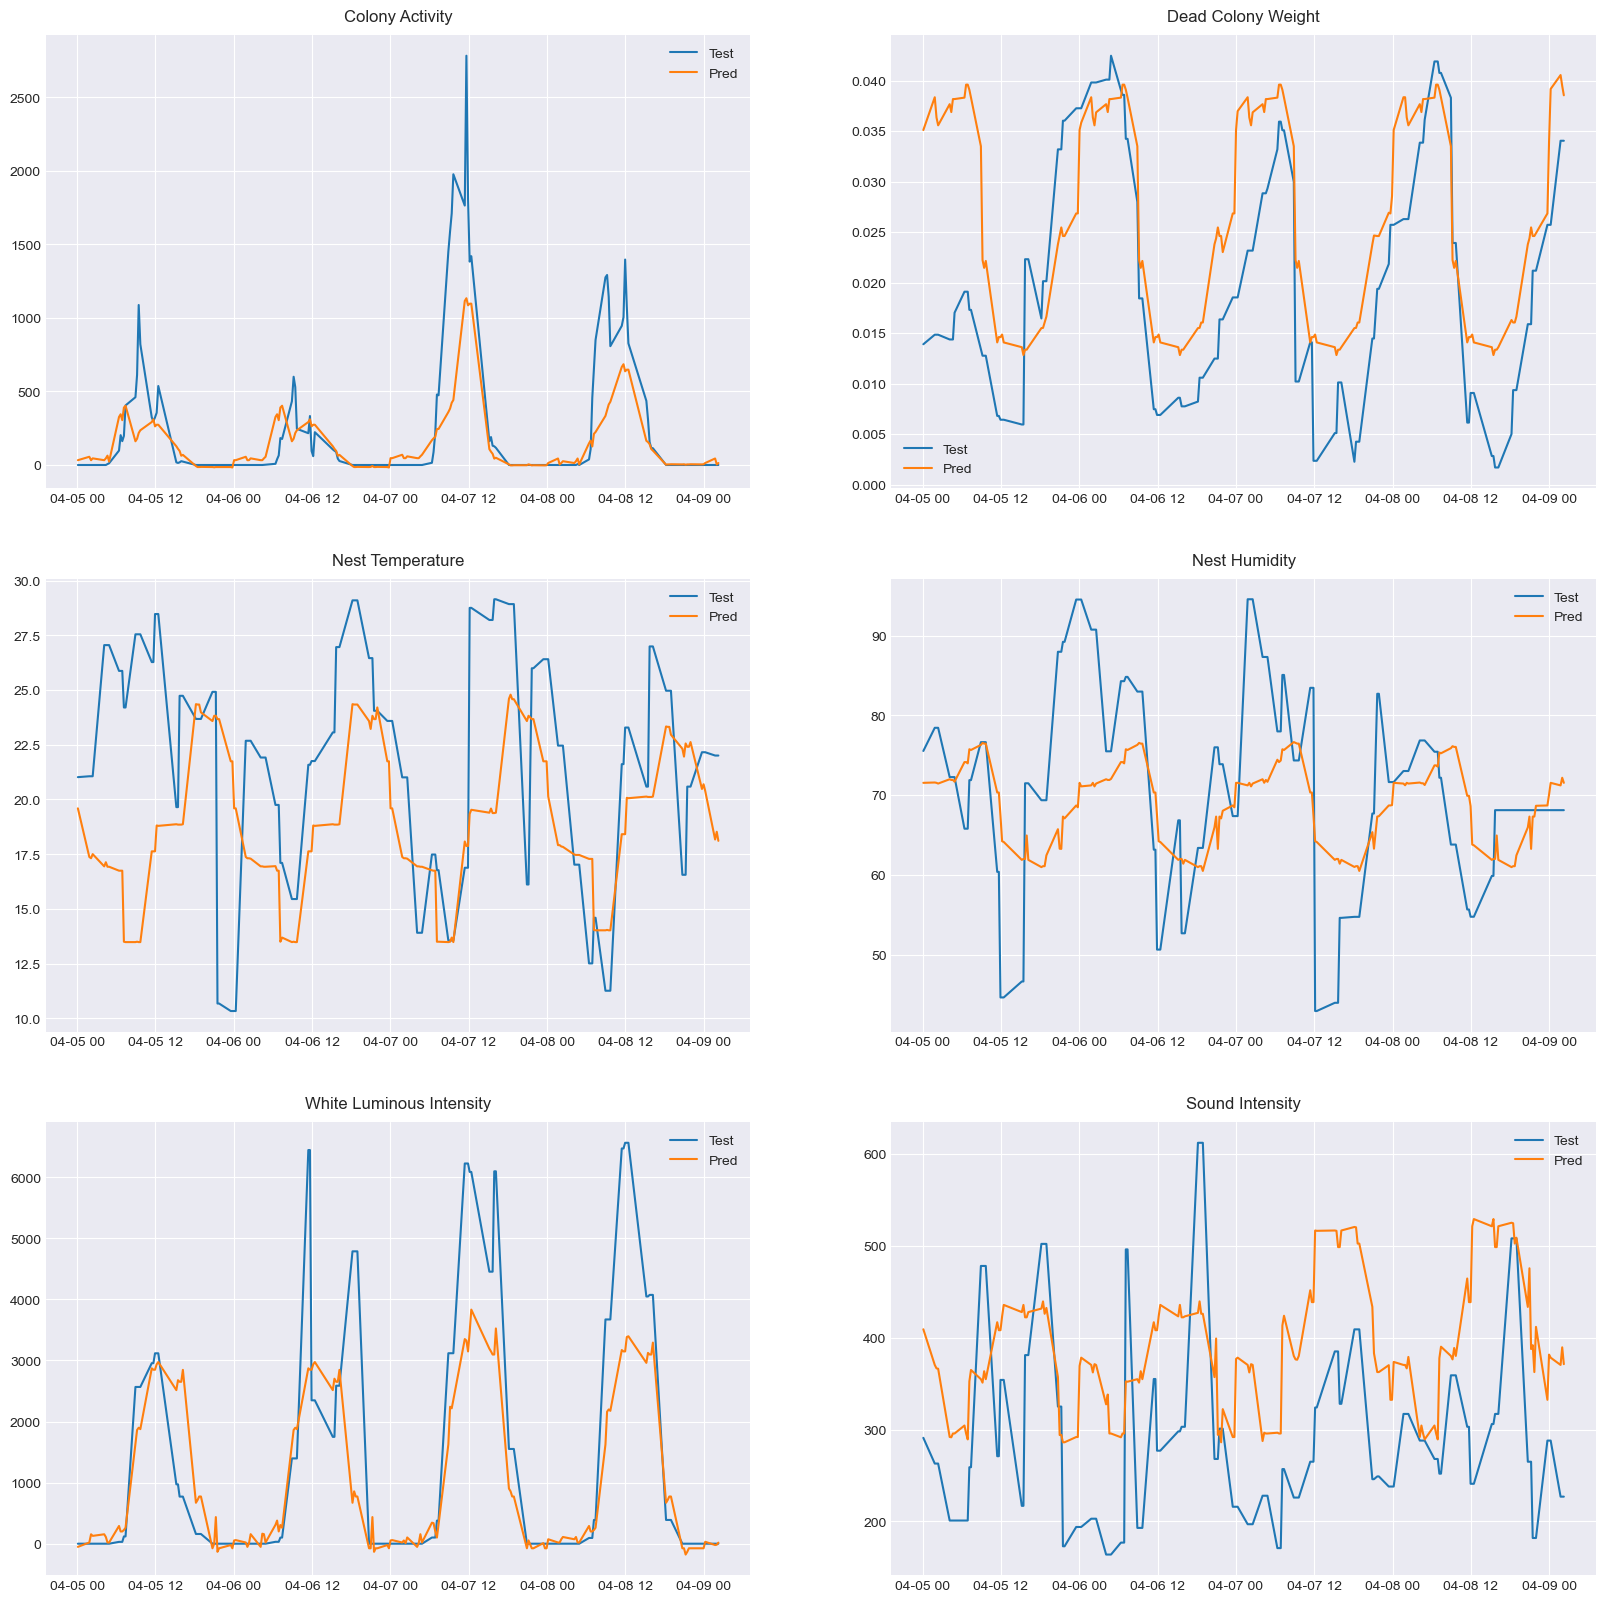

In [33]:
# Training of the regressor 
reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, max_depth = 4, min_child_weight = 0, learning_rate = 0.3)
reg.fit(X_train, exog_train,
        eval_set = [(X_train, exog_train), (X_test, exog_test)],
        verbose = False)

# Prediction on the timestamps to forecast
y_pred= reg.predict(X_test)

# Creating dataframe of the exogenous variables predicted
predictions_df = pd.DataFrame(list(map(np.ravel, y_pred)), index = test.index, columns = exog)

# Plotting the results
fig, ax = plt.subplots(3,2, figsize=(20,20))
row = 0
for i in range(len(exog)):
        col = i % 2
        exog_name = exog[i]
        ax[row,col].set_title(exog_name)
        ax[row,col].plot(test[exog_name], label = 'Test')
        ax[row,col].plot(predictions_df[exog_name], label = 'Pred')
        ax[row,col].legend()
        if col == 1:
                row += 1

plt.show()

After these predictions we create the new dataset to train the XGBoost Regressor

In [34]:
X_train_new = pd.concat([exog_train, X_train], axis=1)
X_test_new = pd.concat([predictions_df, X_test], axis=1)

# Creating the new dataset with predicted exogenous
df_new = pd.concat([X_train_new, X_test_new], axis=0) 
df_new['Nest Weight'] = df['Nest Weight']
df_new['Nest_Weight_diff'] = df['Nest_Weight_diff']


features = ['Month', 'Day', 'Hour', 'Minutes', 'Colony Activity', 'Dead Colony Weight', 'Nest Temperature',
       'Nest Humidity', 'White Luminous Intensity', 'Sound Intensity']

target = 'Nest_Weight_diff'

### Cross validation and tuning
The code is basically the same but in the model we use the exogenous variables

In [35]:
tss = TimeSeriesSplit(n_splits = 3, test_size = 100)

# Parameters' space
max_depth_lst = list(range(1,6))
min_child_w_lst = list(range(0,7))
l_r_lst = list(range(0,5))

scores = []
models = []

# Hyperparameter tuning
for max_depth in max_depth_lst:
    for min_child_weight in min_child_w_lst:
            for l_r in l_r_lst:
                learning_rate = l_r/10
                
                scores_cv = []

                # 3-fold Cross validation
                for train_idx, val_idx in tss.split(df_new):

                        train = df_new.iloc[train_idx]
                        test = df_new.iloc[val_idx]
                        
                        X_train = train[features]
                        y_train = train[target]

                        X_test = test[features]
                        y_test = test[target]


                        # Training the model
                        reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, max_depth = max_depth, 
                                               min_child_weight = min_child_weight, learning_rate = learning_rate, booster = 'gbtree')
                        
                        reg.fit(X_train, y_train,
                                eval_set = [(X_train, y_train), (X_test, y_test)],
                                verbose = False)
                        

                        # Predicting the target for the test dataset
                        y_pred= reg.predict(X_test)

                        # Transformation from Nest_Weight_diff to Nest Weight
                        y_pred_diff = list(y_pred)
                        nest_weight_last = train['Nest Weight'][-1]
                        y_pred = [nest_weight_last]
                        for j in y_pred_diff[1:]:
                                nest_weight_last += j
                                y_pred.append(nest_weight_last)

                        # Mean squared error metric to evaluate the performance for every training in the cv
                        mse = mean_squared_error(y_pred, test['Nest Weight'])
                        scores_cv.append(mse)
                        
          
                # Take the mean of mean squared errors of the cross validation as score for the tuning
                score = np.mean(scores_cv)

                print('*********************\nParameters:')
                print(f'Max Depth: {max_depth}')
                print(f'Min Child Weight: {min_child_weight}')
                print(f'Learning rate: {learning_rate}')
                print (f"MSE: {round(score, 3)}")

                # Save the model and the performance metric
                param_score = (max_depth, min_child_weight, learning_rate, score)
                models.append(param_score)


# Selecting best model by finding the smallest mse
scores = [x[-1] for x in models]
index = scores.index(min(scores))
best_model = models[index]

print('*********** Best Model ***********')
print(f'Max Depth: {best_model[0]}')
print(f'Min Child Weight: {best_model[1]}')
print(f'Learning rate: {best_model[2]}')
print ("MSE:", round(best_model[3]))



*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.0
MSE: 875.218
*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.1
MSE: 3.296
*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.2
MSE: 3.219
*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.3
MSE: 3.222
*********************
Parameters:
Max Depth: 1
Min Child Weight: 0
Learning rate: 0.4
MSE: 3.299
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.0
MSE: 875.218
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.1
MSE: 3.296
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.2
MSE: 3.219
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.3
MSE: 3.222
*********************
Parameters:
Max Depth: 1
Min Child Weight: 1
Learning rate: 0.4
MSE: 3.299
*********************
Para

### Best model 

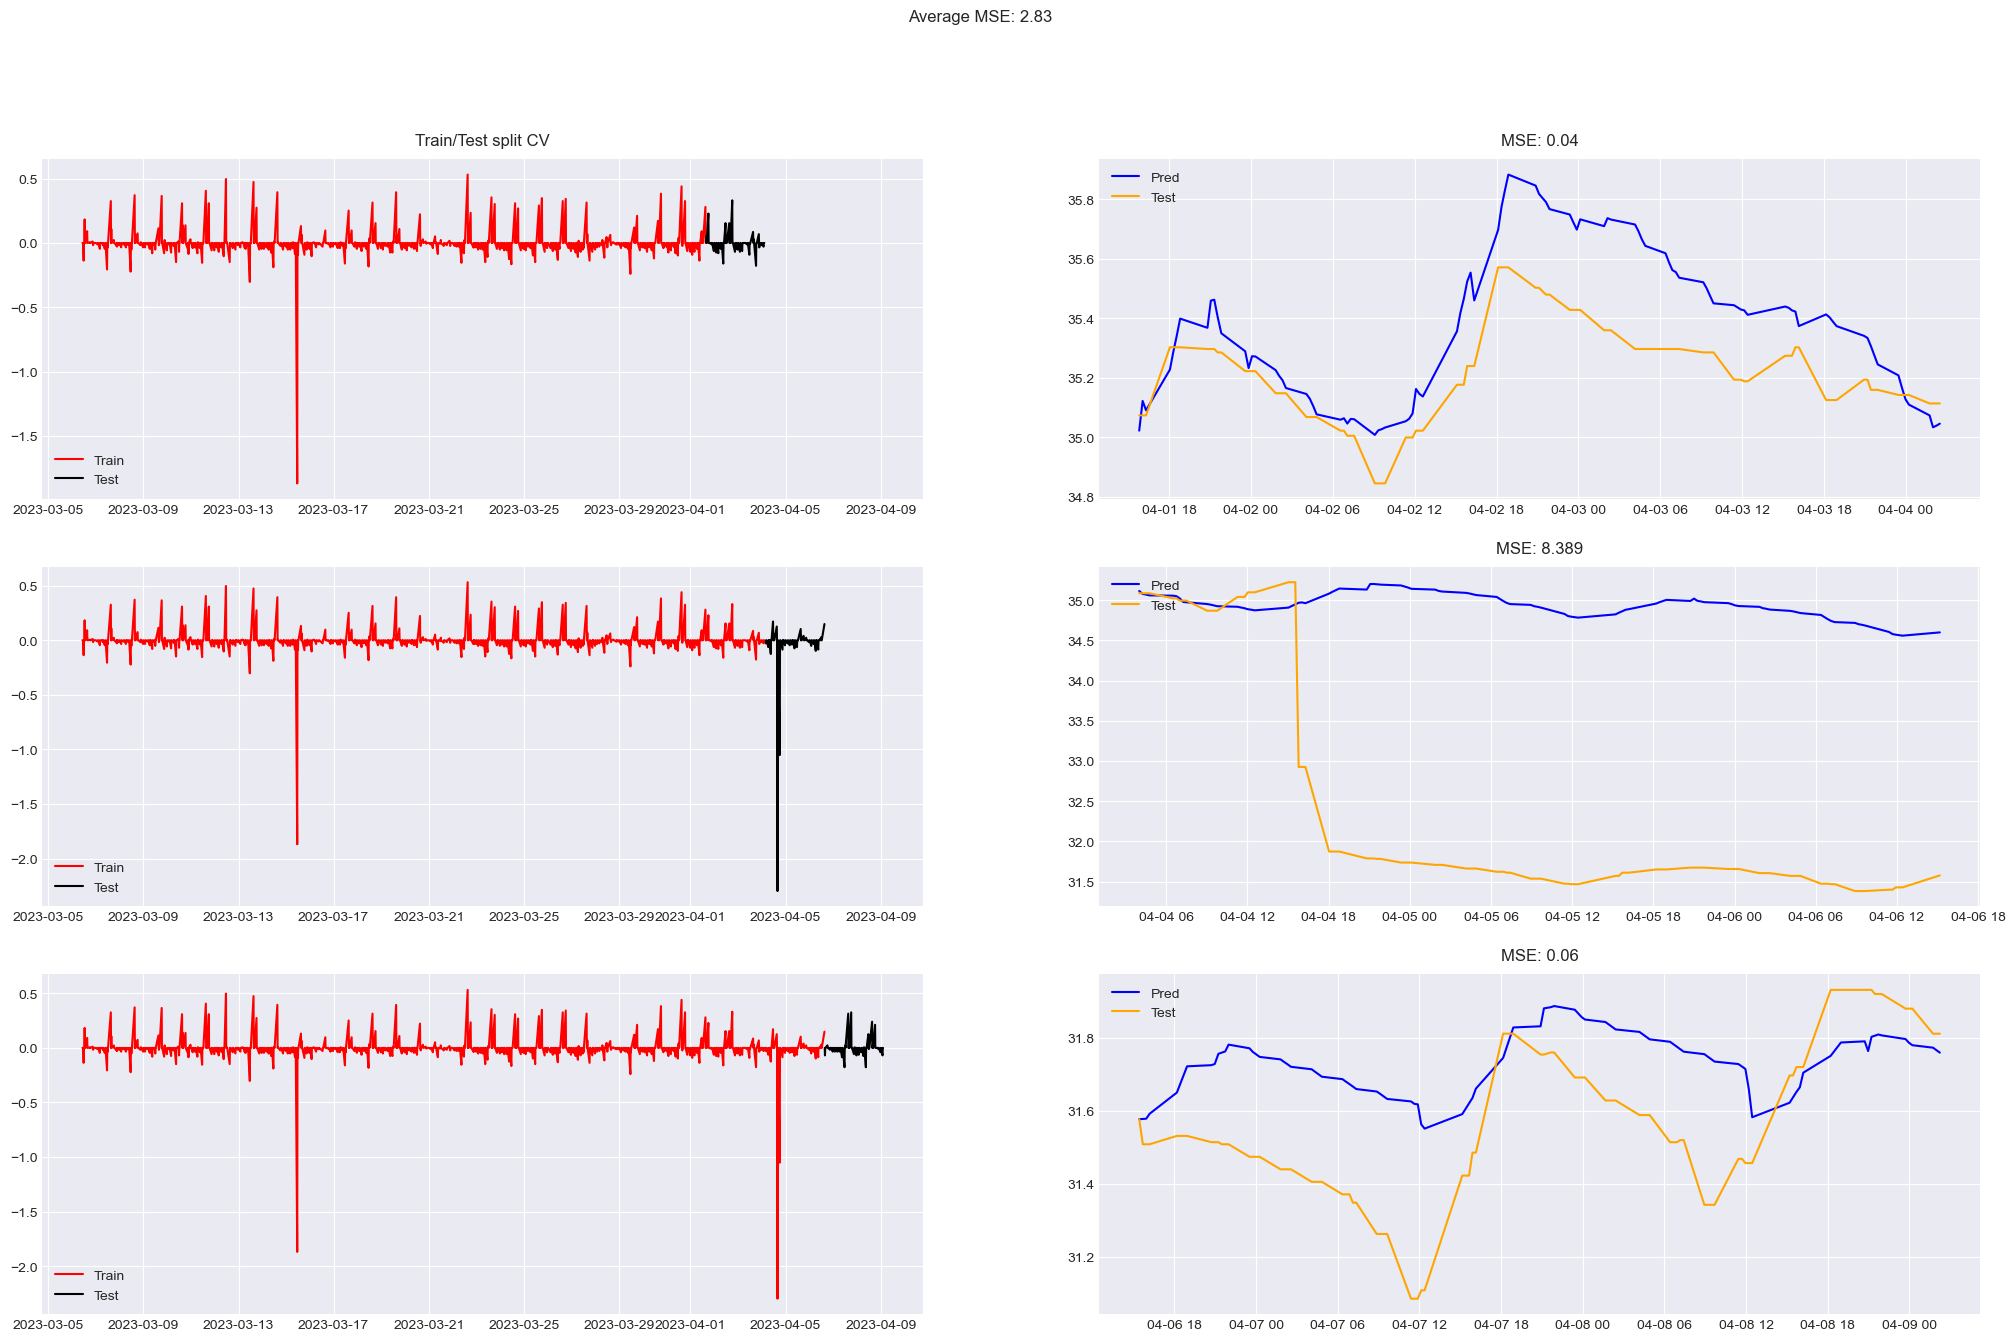

In [36]:
# Re-run the best model and plot the results

fig,ax = plt.subplots(3,2, figsize = (25,15))
i = 0
scores_cv = []
for train_idx, val_idx in tss.split(df_new):
        
        train = df_new.iloc[train_idx]
        test = df_new.iloc[val_idx]

        ax[i,0].plot(train[target], color = 'red', label = 'Train')
        ax[i,0].plot(test[target], color = 'black', label = 'Test')
        
        X_train = train[features]
        y_train = train[target]

        X_test = test[features]
        y_test = test[target]

        reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, max_depth = best_model[0], min_child_weight = best_model[1], learning_rate = best_model[2], booster = 'gbtree')
        reg.fit(X_train, y_train,
                eval_set = [(X_train, y_train), (X_test, y_test)],
                verbose = False)

        y_pred= reg.predict(X_test)

        y_pred_diff = list(y_pred)
        nest_weight_last = train['Nest Weight'][-1]
        y_pred = [nest_weight_last]
        for j in y_pred_diff[1:]:
                nest_weight_last += j
                y_pred.append(nest_weight_last)
                
        score = mean_squared_error(y_pred, test['Nest Weight'])
        scores_cv.append(round(score,3))
        
        ax[i,1].plot(X_test.index, y_pred, color = 'blue', label = 'Pred')
        ax[i,1].plot(X_test.index, test['Nest Weight'], color = 'orange', label = 'Test')
        ax[i,1].legend(loc = 'upper left')
        ax[i,0].legend(loc = 'lower left')
        ax[i,1].set_title(f'MSE: {round(score, 3)}')
        i+=1


score_cv = np.mean(scores_cv)

fig.suptitle(f'Average MSE: {round(score_cv, 3)}')
ax[1,0].sharex(ax[2,0])
ax[0,0].sharex(ax[2,0])
ax[0,0].set_title('Train/Test split CV')
plt.show()


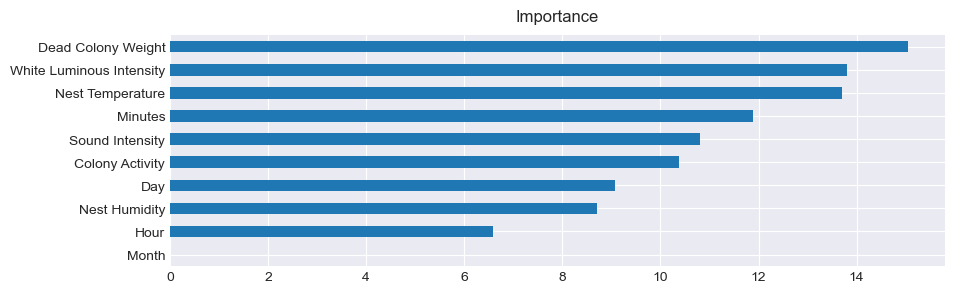

In [37]:
# Plotting the feature importance as percentages
impor = pd.DataFrame(data = reg.feature_importances_ * 100, index = reg.feature_names_in_, columns = ['importance'])
impor.sort_values('importance').plot(kind = 'barh', title = 'Importance', legend=False, figsize = (10,3))
plt.show()

So we can see that Month has no importance but we expected it (see first model's feature importance). Then we can see that the first three variables in importance are 'Dead Colony Weight', 'White Luminous Intensity', 'Nest Temperature'. 'Nest Humidity' has not much importance but it is correlated to the temperature (as we've seen in Power BI) so it can be that Nest Temperature covers much of the information that they can give. Same thing for Dead Colony Weight with Colony Activity (negative correlation).

## Submission prediction

Now that we've found the best model we can use the submission_data for prediction. But this time:  
- First, we predict the exogenous variables for the submission_data
- Second, we create the dataset of submission data with the exogenous
- Finally, we use this whole dataset to predict the target

In [38]:
features = ['Month', 'Day', 'Hour', 'Minutes']

exog = ['Colony Activity', 'Dead Colony Weight', 'Nest Temperature',
       'Nest Humidity', 'White Luminous Intensity', 'Sound Intensity']

target = 'Nest_Weight_diff'

X_train = df[features]
exog_train = df[exog]
y_train = df[target]

X_test = df_sub[features]

### Exogenous prediction

We use the same model as before to predict the exogenous

In [39]:
# Training of the regressor 
reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, max_depth = 4, min_child_weight = 0, learning_rate = 0.3)
reg.fit(X_train, exog_train,
        eval_set = [(X_train, exog_train)],
        verbose = False)

# Prediction on the timestamps to forecast
y_pred= reg.predict(X_test)
y_pred.shape

# Creating dataframe of the exogenous variables predicted
predictions_df = pd.DataFrame(list(map(np.ravel, y_pred)), index = df_sub.index, columns = exog)
predictions_df

,Colony Activity,Dead Colony Weight,Nest Temperature,Nest Humidity,White Luminous Intensity,Sound Intensity
Date,,,,,,
2023-04-09 02:29:00,-30.733133,0.035625,21.898890,70.741905,-59.719109,254.654053
2023-04-09 04:14:00,6.917559,0.036050,15.582800,70.466331,5.558601,220.575043
2023-04-09 04:28:00,8.465827,0.039839,15.598052,73.121948,-48.926807,230.249832
2023-04-09 04:58:00,82.000252,0.042567,16.634228,71.561951,-261.173004,290.496490
2023-04-09 06:28:00,190.188095,0.044464,13.266581,70.491013,63.006733,173.283524
...,...,...,...,...,...,...
2023-04-12 21:39:00,14.169519,0.048679,22.840179,71.610992,308.907654,126.377197
2023-04-12 21:54:00,-11.576927,0.047594,23.392925,74.060211,-46.819809,122.787361
2023-04-12 23:24:00,20.437210,0.051640,22.119488,66.935844,-55.112396,178.721237


We can use the exogenous predicted to help the model predict our target

In [40]:
# Creation of dataset of submission with the exogenous variables predicted
df_sub_ex = pd.concat([df_sub, predictions_df], axis = 1)

features = ['Month', 'Day', 'Hour', 'Minutes', 'Colony Activity', 'Dead Colony Weight', 'Nest Temperature',
       'Nest Humidity', 'White Luminous Intensity', 'Sound Intensity']

target = 'Nest_Weight_diff'

X_train = df[features]
X_test = df_sub_ex[features]

### Target prediction

Now we use the best model found before to predict the target with the exogenous variables, plot the results and save the predictions in prediction_xgboost_w_ex

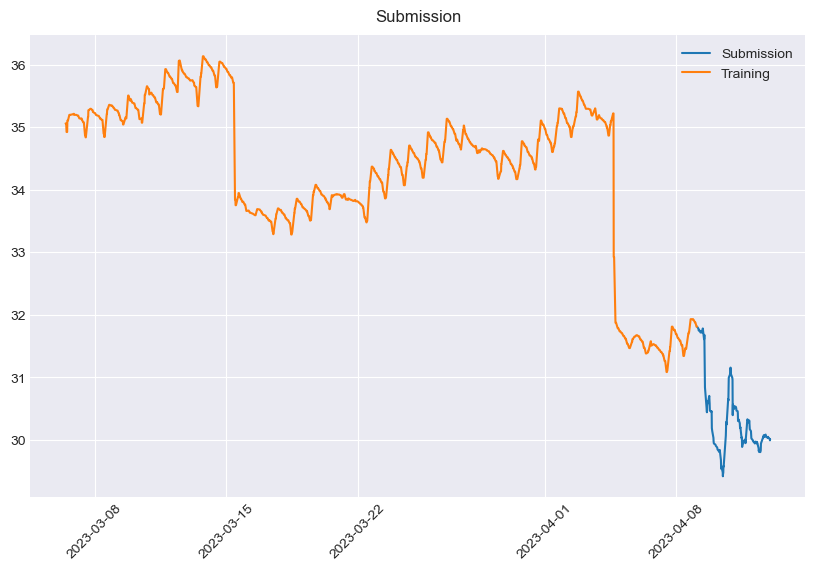

In [41]:
# Training the best model on the entire train_data

reg = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, max_depth = best_model[0], min_child_weight = best_model[1], learning_rate = best_model[2], booster = 'gbtree')
reg.fit(X_train, y_train,
    eval_set = [(X_train, y_train)],
    verbose = False)

# Predicting the target for submission_data with exogenous
y_pred= reg.predict(X_test)

# Transforming Nest_Weight_diff predictions in Nest Weight predictions
y_pred_diff = list(y_pred)
nest_weight_last = df['Nest Weight'][-1]
y_pred = [nest_weight_last]
for j in y_pred_diff[1:]:
    nest_weight_last += j
    y_pred.append(nest_weight_last)

# Plotting the results
plt.figure(figsize = (10,6))  
plt.title('Submission')      
plt.plot(df_sub_ex.index, y_pred, label = 'Submission')
plt.plot(df.index, df['Nest Weight'], label = 'Training')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [42]:
# Saving the prediction
prediction_xgboost_w_ex = y_pred[:]

## Predictions dataset

Now we have both the predictions with and without exogenous variable. We can add the columns of these predictions to the original dataset and export it as a result.

In [43]:
df_sub_ex['Nest_Weight_pred_wout_ex'] = prediction_xgboost_wout_ex
df_sub_ex['Nest_Weight_pred_w_ex'] = prediction_xgboost_w_ex

In [44]:
df_sub_ex.to_csv('submission_xgboost.csv', sep = ',')

## SARIMAX


Now we use the model SARIMAX. The first thing we notice is that to use this model we must have a regular time series (with a frequency). So we study our dataset to uderstand the best frequency to use.

### Regularization of the time series

First we applied the differencing method to the timestamps. This method returns all timedeltas that we converted in minutes

In [45]:
def get_minutes_td(td):
    return td.total_seconds()/60

df_diff = pd.Series(df.index).diff().dropna()
timedeltas = list(df_diff)
timedeltas = list(map(get_minutes_td, timedeltas))
timedeltas.sort()
print(dict(collections.Counter(timedeltas)))

{14.0: 13, 15.0: 965, 16.0: 53, 29.0: 1, 30.0: 12, 61.0: 1, 89.0: 5, 90.0: 75, 91.0: 43, 92.0: 6, 103.0: 1, 104.0: 1, 105.0: 58, 106.0: 22, 107.0: 2, 108.0: 1, 120.0: 30, 121.0: 16, 122.0: 2, 135.0: 4, 136.0: 1, 150.0: 8, 151.0: 6, 165.0: 14, 166.0: 4, 167.0: 1, 195.0: 1}


We can see how every timedelta is about a multipltle of 15 and that the timedeltas of 15 minutes is the most frequent one. So we can think that originally the data is collected with a frequency of 15 minutes but some data went lost. At this point we resample our time series in order to have a frequency of 15 minutes. The obseervations added are originally NaN values for every variable, but with an interpolation we can fix that.

### Resampling

In [46]:
df1 = df.copy()

# We drop these columns because Sarimax doesn't need them unlike the trees
df1 = df1.drop(['Minutes', 'Hour', 'Day', 'Month'], axis = 1)
# The .interpolate() method without arguments uses the linear method to interpolate data
df1 = df1.resample('15T').mean().interpolate() 

df1['Nest_Weight_diff'] = df1['Nest Weight'].diff().fillna(0)

target = 'Nest_Weight_diff'


### Cross validation and tuning
Again, we use a hyperparameters' tuning and cross validation to choose the best model in terms of performance and robustness. The parameters' space this time is:  
- p: from 1 to 3
- q: from 1 to 2
- P: from 1 to 2
- Q: from 1 to 2  

So all the parameters of order and seasonal order except d and D. Again we don't use as target Nest Weight but Nest_Weight_diff because is simpler for the model predict a stationary series.

In [47]:
tss = TimeSeriesSplit(n_splits = 3, test_size = 300)

# Hyperparameters' tuning
for p in range(1,4):
    for q in range(1,3):
        for P in range(1,3):
            for Q in range(1, 3):
                        scores_cv = []

                        # 3-fold cross validation
                        for train_idx, val_idx in tss.split(df1):
                                
                                # Splitting training and testing dataset
                                train = df1.iloc[train_idx]
                                test = df1.iloc[val_idx]
                                
                                y_train = train[target]
                                y_test = test[target]
                                
                                # Training the model
                                model = SARIMAX(y_train,
                                        order = (p,0,q), seasonal_order = (P,0,Q,12), 
                                        enforce_stationarity=True)
                                
                                result = model.fit()

                                # Predicting the target 
                                y_pred = result.predict(start=test.index[0], end=test.index[-1])

                                # Transforming Nest_Weight_diff prediction in Nest Weight prediction
                                y_pred_diff = list(y_pred)
                                nest_weight_last = train['Nest Weight'][-1]
                                y_pred = [nest_weight_last]
                                for j in y_pred_diff[1:]:
                                        nest_weight_last += j
                                        y_pred.append(nest_weight_last)

                                # Evaluating performance with mse
                                mse = mean_squared_error(y_pred, test['Nest Weight'])
                                scores_cv.append(mse)
                                

                        score = np.mean(scores_cv)

                        # Printing the model in use
                        print('*********************\nParameters:')
                        print(f'p: {p}')
                        print(f'q: {q}')
                        print(f'P: {P}')
                        print(f'Q: {Q}')
                        print(f'Score: {round(score, 3)}')
                        
                        # Saving the model
                        param_score = (p, q, P, Q, score)
                        models.append(param_score)
                        
# Finding and printing the best model in terms of performance (Average MSE)                        
scores = [x[-1] for x in models]
index = scores.index(min(scores))
best_model = models[index]

print('*********** Best Model ***********')
print(f'Max Depth: {best_model[0]}')
print(f'Min Child Weight: {best_model[1]}')
print(f'Learning rate: {best_model[2]}')
print ("MSE:", round(best_model[3], 3))


*********************
Parameters:
p: 1
q: 1
P: 1
Q: 1
Score: 2.071
*********************
Parameters:
p: 1
q: 1
P: 1
Q: 2
Score: 2.067
*********************
Parameters:
p: 1
q: 1
P: 2
Q: 1
Score: 2.064
*********************
Parameters:
p: 1
q: 1
P: 2
Q: 2
Score: 2.066
*********************
Parameters:
p: 1
q: 2
P: 1
Q: 1
Score: 2.082
*********************
Parameters:
p: 1
q: 2
P: 1
Q: 2
Score: 2.056
*********************
Parameters:
p: 1
q: 2
P: 2
Q: 1
Score: 2.071
*********************
Parameters:
p: 1
q: 2
P: 2
Q: 2
Score: 2.067
*********************
Parameters:
p: 2
q: 1
P: 1
Q: 1
Score: 2.064
*********************
Parameters:
p: 2
q: 1
P: 1
Q: 2
Score: 2.075
*********************
Parameters:
p: 2
q: 1
P: 2
Q: 1
Score: 2.077
*********************
Parameters:
p: 2
q: 1
P: 2
Q: 2
Score: 2.066
*********************
Parameters:
p: 2
q: 2
P: 1
Q: 1
Score: 2.064
*********************
Parameters:
p: 2
q: 2
P: 1
Q: 2
Score: 2.075
*********************
Parameters:
p: 2
q: 2
P: 2
Q: 1
Score: 2

### Best model

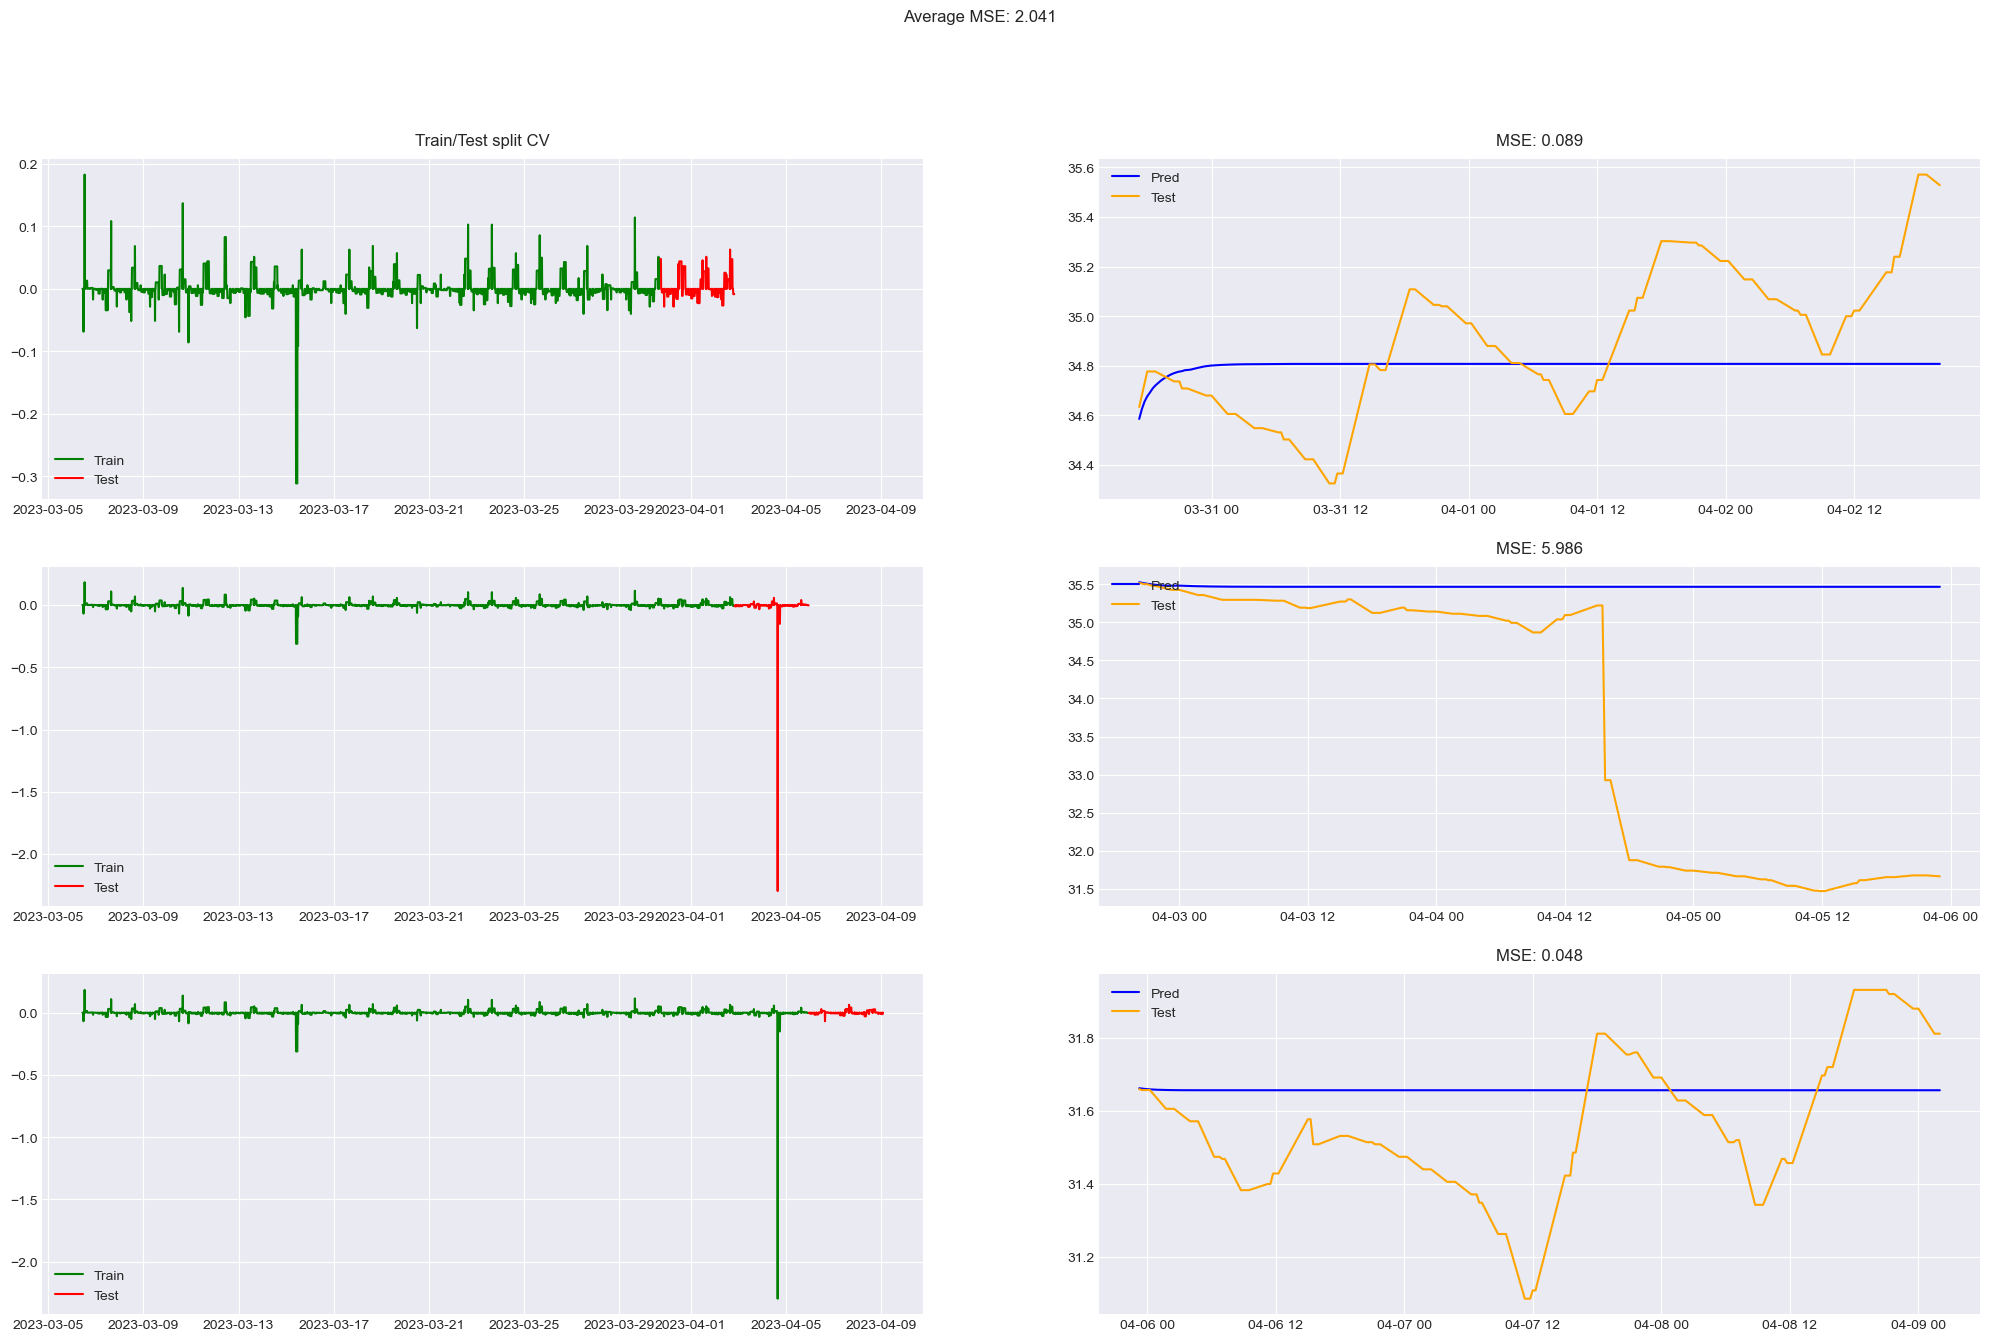

In [48]:
# Re run the best model to show the results
fig,ax = plt.subplots(3,2, figsize = (25,15))
i = 0
scores_cv = []

for train_idx, val_idx in tss.split(df1):
        
        train = df1.iloc[train_idx]
        test = df1.iloc[val_idx]

        # Plotting train and test split
        ax[i,0].plot(train[target], color = 'green', label = 'Train')
        ax[i,0].plot(test[target], color = 'red', label = 'Test')


        y_train = train[target]

        y_test = test[target]

        model = SARIMAX(y_train,
                order = (best_model[0],0,best_model[1]), 
                seasonal_order = (best_model[2],0,best_model[3],12), 
                enforce_stationarity=True)

        result = model.fit()

        y_pred = result.predict(start=test.index[0], end=test.index[-1])

        y_pred_diff = list(y_pred)
        nest_weight_last = train['Nest Weight'][-1]
        y_pred = [nest_weight_last]
        for j in y_pred_diff[1:]:
                nest_weight_last += j
                y_pred.append(nest_weight_last)

        mse = mean_squared_error(y_pred, test['Nest Weight'])
        scores_cv.append(round(mse,3))

        # Plotting predictions and test values 
        ax[i,1].plot(test.index, y_pred, color = 'blue', label = 'Pred')
        ax[i,1].plot(test.index, test['Nest Weight'], color = 'orange', label = 'Test')
        ax[i,1].set_title(f'MSE: {scores_cv[i]}')
        ax[i,1].legend(loc = 'upper left')
        ax[i,0].legend(loc = 'lower left')
        i+=1

score_cv = np.mean(scores_cv)

# Plotting results
fig.suptitle(f'Average MSE: {round(score_cv, 3)}')
ax[1,0].sharex(ax[2,0])
ax[0,0].sharex(ax[2,0])
ax[0,0].set_title('Train/Test split CV')
plt.show()

At this point we can use a function of Sarimax that is the confidence interval for example in the last prediction. The confidence interval is 95%.

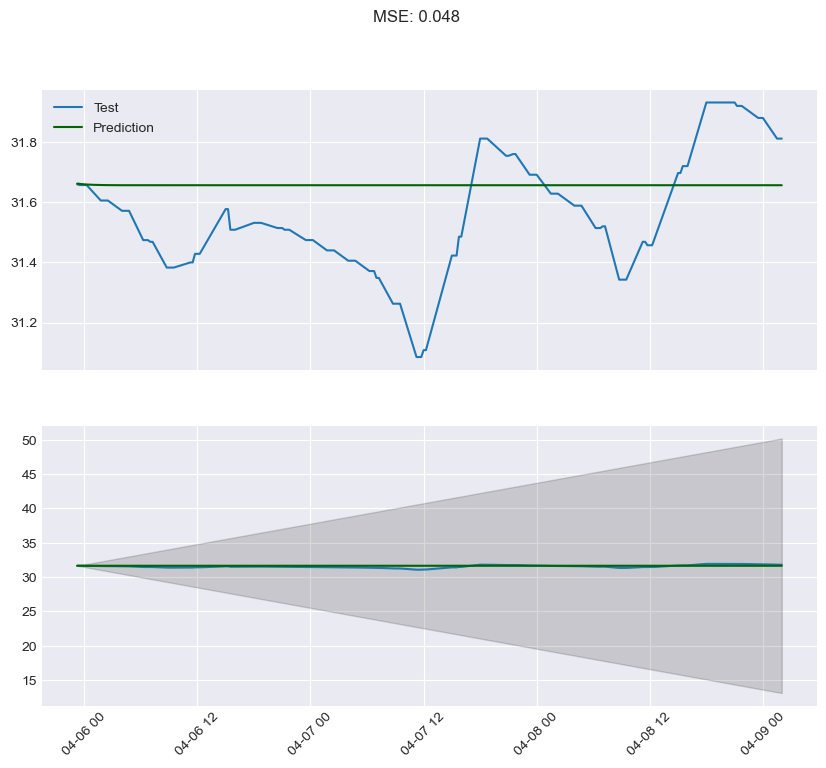

In [49]:
preds_df = (result
            .get_prediction(start=test.index[0], end=test.index[-1])
            .summary_frame(alpha=0.2))
preds_df

fig, axs = plt.subplots(2, 1, sharex = True, figsize = (10,8))

# Transforming Nest_Weight_diff prediction in Nest Weight prediction
y_pred_diff = list(preds_df['mean'])
nest_weight_last = train['Nest Weight'][-1]
y_pred = [nest_weight_last]
for j in y_pred_diff[1:]:
        nest_weight_last += j
        y_pred.append(nest_weight_last)

# Transforming Nest_Weight_diff lower series in Nest Weight lower series
y_pred_lower_diff = list(preds_df['mean_ci_lower'])
nest_weight_last = train['Nest Weight'][-1]
y_pred_lower = [nest_weight_last]
for j in y_pred_lower_diff[1:]:
        nest_weight_last += j
        y_pred_lower.append(nest_weight_last)


# Transforming Nest_Weight_diff upper series in Nest Weight upper series
y_pred_upper_diff = list(preds_df['mean_ci_upper'])
nest_weight_last = train['Nest Weight'][-1]
y_pred_upper = [nest_weight_last]
for j in y_pred_upper_diff[1:]:
        nest_weight_last += j
        y_pred_upper.append(nest_weight_last)

# Plotting first testing and predictions and then add the confidence interval
mse = mean_squared_error(y_pred, test['Nest Weight'])
fig.suptitle(f'MSE: {round(mse, 3)}')
plt.xticks(rotation = 45)

axs[0].plot(test.index, test['Nest Weight'], label = 'Test')
axs[0].plot(test.index, y_pred, color='darkgreen', label = 'Prediction')


axs[1].plot(test.index, test['Nest Weight'], label = 'Test')
axs[1].plot(test.index, y_pred, color='darkgreen', label = 'Prediction')
axs[1].fill_between(test.index,
                y_pred_lower,
                y_pred_upper,
                color='k', alpha=.15)
axs[0].legend(loc = 'upper left')
plt.show()


## Submission prediction

In [50]:
# Importing submissiondata.csv
df_sub_sar = pd.read_csv('submission_data.csv')

# Convert Date variable from string to timestamp
df_sub_sar['Date']= pd.to_datetime(df_sub_sar['Date'], format='%Y-%m-%d %H:%M:%S')


# Round all timestamps to the minutes (seconds = 00)
df_sub_sar['Date'] = df_sub_sar['Date'].apply(minute_round)

In [51]:
# Timestamp as index
df_sub_sar.index = pd.to_datetime(df_sub_sar['Date'], format='%Y-%m-%d %H:%M:%S')
del df_sub_sar['Date']

Again, on submission data we use the resampling method to give a frequency of 15 minutes.  
(We dropped the first row because the original dataset begin with 02:29 but after the interpolation the dataset begins with 02:15)

In [52]:
# Resampling submission dataset
df_sub_sar = df_sub_sar.resample('15T').mean().interpolate() 
df_sub_sar = df_sub_sar.iloc[1:]

We use the best model in performance that we've found to predict the Nest Weight in the submission data timestamps

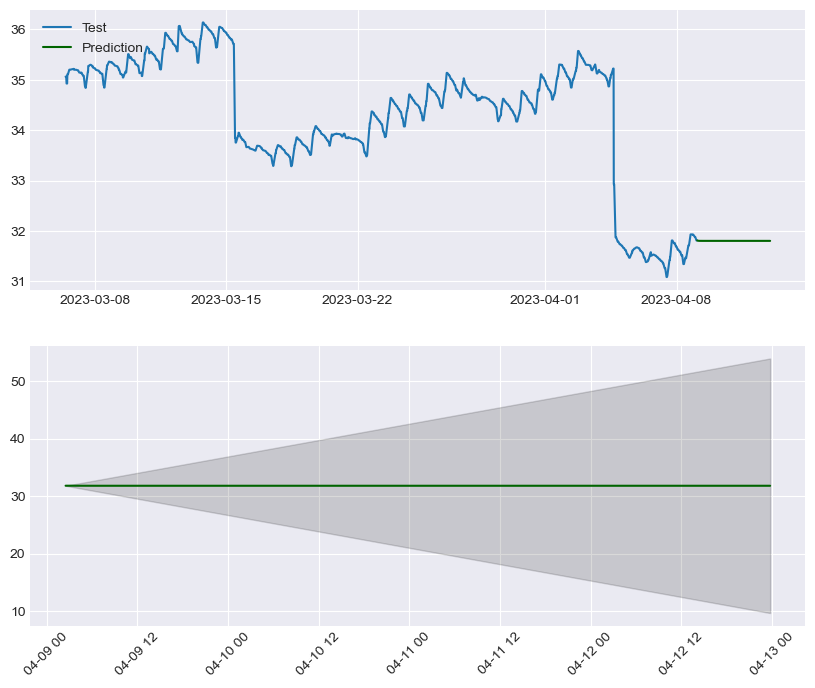

In [53]:
y_train = df1[target]

# Training the best model on the whole train dataset
model = SARIMAX(y_train,
                order = (best_model[0],0,best_model[1]), 
                seasonal_order = (best_model[2],0,best_model[3],12), 
                enforce_stationarity=True)

result = model.fit()

# Predicting the target for the submission_data time stamps with confidence intervals
preds_df = (result
            .get_prediction(start=df_sub_sar.index[0], end=df_sub_sar.index[-1])
            .summary_frame(alpha=0.2))


fig, axs = plt.subplots(2, 1, figsize = (10,8))

# Transforming Nest_Weight_diff prediction in Nest Weight prediction
y_pred_diff = list(preds_df['mean'])
nest_weight_last = df1['Nest Weight'][-1]
y_pred = [nest_weight_last]
for j in y_pred_diff[1:]:
        nest_weight_last += j
        y_pred.append(nest_weight_last)

# Transforming Nest_Weight_diff lower series in Nest Weight lower series
y_pred_lower_diff = list(preds_df['mean_ci_lower'])
nest_weight_last = df1['Nest Weight'][-1]
y_pred_lower = [nest_weight_last]
for j in y_pred_lower_diff[1:]:
        nest_weight_last += j
        y_pred_lower.append(nest_weight_last)


# Transforming Nest_Weight_diff upper series in Nest Weight upper series
y_pred_upper_diff = list(preds_df['mean_ci_upper'])
nest_weight_last = df1['Nest Weight'][-1]
y_pred_upper = [nest_weight_last]
for j in y_pred_upper_diff[1:]:
        nest_weight_last += j
        y_pred_upper.append(nest_weight_last)

# Plotting first testing and predictions and then add the confidence interval

plt.xticks(rotation = 45)

axs[0].plot(df1.index, df1['Nest Weight'], label = 'Test')
axs[0].plot(df_sub_sar.index, y_pred, color='darkgreen', label = 'Prediction')


axs[1].plot(df_sub_sar.index, y_pred, color='darkgreen', label = 'Prediction')
axs[1].fill_between(df_sub_sar.index,
                y_pred_lower,
                y_pred_upper,
                color='k', alpha=.15)

axs[0].legend(loc = 'upper left')
plt.show()

    

Finally we can save the prediction with the confidence interval and then we add the columns to the resampled dataset. Then we can export this dataset as a result.

In [54]:
# Saving results of prediction
prediction_sarimax = y_pred[:]
prediction_sarimax_lower = y_pred_lower[:]
prediction_sarimax_upper = y_pred_upper[:]

## Prediction dataset

In [55]:
# Add results' columns to the resampled dataset
df_sub_sar['Nest Weight'] = prediction_sarimax
df_sub_sar['Nest_Weight_upper'] = prediction_sarimax_lower
df_sub_sar['Nest_Weight_lower'] = prediction_sarimax_upper


In [56]:
# Export dataset
df_sub_sar.to_csv('submission_sarimax_resampled.csv', sep = ',')

# Conclusion

So we can sum up saying that we used two models: XGBoost and SARIMAX. The XGBoost was used also with predicted exogenous variables. Unfortunately, we couldn't find a goood model that take exogenous variables in training and doesn't need them in the forecasting.  
The results after tuning with 3-fold cross validation are:  
- XGBoost (without exogenous variables): 3.143
- XGBoost (with predicted exogenous variables): 2.83
- SARIMAX (without exogenous variables): 2.041  

For the XGBoost we saw that the predictions of the exogenous was not bad at all, also because all the exogenous were stationary and so not difficult to predict.  
We noticed that also without exogenous it comes up with a good prediction.
Sure the SARIMAX mean squared error is lower but it gives a straight line as prediction. It can't seem to understand trend and seasonality of the data. Maybe it's because this model is used for bigger datasets. 

In general, there is to say that all the models can't seem to predict the drop that comes up on 04/04. We, also, can't give an explanation for this drop and the one on 15/03. 

